# 0.0 General Area

## 0.1 Import Libraries

In [1]:
import pandas            as pd
import numpy             as np
import seaborn           as sns
import matplotlib.pyplot as plt
import xgboost           as xgb

import math 
import inflection
import datetime
import pickle
import warnings
import random


from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model  import LinearRegression, Lasso
from sklearn.ensemble      import RandomForestRegressor
from sklearn.metrics       import mean_absolute_error, mean_squared_error

from IPython.display       import Image
from tabulate              import tabulate
from boruta                import BorutaPy

from scipy                 import stats as ss

warnings.filterwarnings( 'ignore' )

## 0.2 Support Functions

In [2]:
def rename_columns( df ):
    title = lambda x: inflection.titleize( x )
    snakecase = lambda x: inflection.underscore( x )
    spaces = lambda x: x.replace(" ", "")

    cols_old = list( df.columns )
    cols_old = list( map( title, cols_old ) )
    cols_old = list( map( spaces, cols_old ) )
    cols_new = list( map( snakecase, cols_old ) )
    
    df.columns = cols_new

    return df

def fillout_na( df ):
    # competition_distance with NA values means "no competitor around". Set max value = 200000
    max_value = df['competition_distance'].max()
    df['competition_distance'] = df['competition_distance'].apply( lambda x: 200000 if math.isnan( x ) else x )

    # competition_open_since_month and competition_open_since_year 
    # Set month and year of sale as default value
    df['competition_open_since_month'] = df.apply( lambda x: x['date'].month if math.isnan( x['competition_open_since_month'] ) else x['competition_open_since_month'], axis=1 )
    df['competition_open_since_year']  = df.apply( lambda x: x['date'].year if math.isnan(  x['competition_open_since_year'] )  else x['competition_open_since_year'], axis=1 )

    # promo2_since_week  and promo2_since_year
    # Set month and year of sale as default value
    df['promo2_since_week'] = df.apply( lambda x: x['date'].week if math.isnan( x['promo2_since_week'] ) else x['promo2_since_week'], axis=1 )
    df['promo2_since_year'] = df.apply( lambda x: x['date'].year if math.isnan( x['promo2_since_year'] ) else x['promo2_since_year'], axis=1 )

    # promo_interval  - first, create a new column(month_map) with the month of sale  
    month_map = { 1: 'Jan', 2: 'Feb', 3: 'Mar', 4: 'Apr', 5: 'May', 6: 'Jun', 7: 'Jul', 8: 'Aug', 9: 'Sep', 10: 'Oct', 11: 'Nov', 12: 'Dec' }
    df['promo_interval'].fillna( 0, inplace=True )
    df['month_map'] = df['date'].dt.month.map( month_map )

    # promo_inteval - second, create a new column(is_promo) to check two conditions:  if promo_interval is active (1) and if month_map is inside promo_interval. (0) No, (1) Yes
    df['is_promo'] = df[['promo_interval', 'month_map']].apply( lambda x: 0 if x['promo_interval'] == 0 else 1 if x['month_map'] in x['promo_interval'].split( ',' ) else 0, axis=1 ) 

    return df

def change_data_types( df ):
    df['competition_open_since_month']  = df['competition_open_since_month'].astype( int )
    df['competition_open_since_year']   = df['competition_open_since_year'].astype( int )
    df['promo2_since_week']             = df['promo2_since_week'].astype( int )
    df['promo2_since_year']             = df['promo2_since_year'].astype( int )

    return df 


def data_cleaning( df ):

    df = rename_columns( df )
    df = fillout_na( df )
    df = change_data_types( df )

    return df


def create_features( df ):
    # year
    df['year'] = df['date'].dt.year

    # month
    df['month'] = df['date'].dt.month

    # day
    df['day'] = df['date'].dt.day

    # week of year
    df['week_of_year'] = df.apply( lambda x: datetime.date( x['year'], x['month'], x['day'] ).isocalendar().week, axis=1 )

    # year week
    df['year_week'] = df.apply( lambda x: str( x['year'] ) + '-' + str( x['week_of_year'] ), axis=1 )

    # from competition_open_since columns
    df['competition_since']      = df.apply( lambda x: datetime.datetime( year=x['competition_open_since_year'], month=x['competition_open_since_month'], day=1 ), axis=1 )
    df['competition_time_month'] = df.apply( lambda x: ( ( x['date'] - x['competition_since'] ) / 30 ).days, axis=1 ).astype( int )

    # from promo2_since
    df['promo2_since']     = df['promo2_since_year'].astype( str ) + '-' + df['promo2_since_week'].astype( str )
    df['promo2_since']     = df['promo2_since'].apply( lambda x: datetime.datetime.strptime( x +'-1', '%Y-%W-%w' ) - datetime.timedelta( days=7 ) )
    df['promo2_time_week'] = df.apply( lambda x: ( ( x['date'] - x['promo2_since'] ) / 7 ).days, axis=1 ).astype( int )

    #  describes an assortment level: a = basic, b = extra, c = extended
    df['assortment'] = df['assortment'].apply( lambda x: 'basic' if x == 'a' else 'extra' if x =='b' else 'extended' )

    # Normally all stores, with few exceptions, are closed on state holidays. Note that all schools are closed on public holidays and weekends. 
    # a = public holiday, b = easter holiday, c = christmas, 0 = regular day
    df['state_holiday'] = df['state_holiday'].apply( lambda x: 'public holiday' if x == 'a' else 'easter holiday' if x == 'b' else 'christmas' if x == 'c' else 'regular day' )

    return df

def remove_rows( df ):
    # remove lines where there are no sales
    df = df[ ( df['open'] != 0 ) & ( df['sales'] > 0 ) ]

    return df

def drop_cols( df ):
    # customers -> Quantidade de clientes nas lojas, não é possível saber quantos clientes estarão nas lojas na predição. 
    # open -> Se a loja está aberta ou não. Quando está fechada não há vendas, ou seja, devem ser consideradas apenas as linhas com loja aberta ( open != 0 )
    # sales -> Valor total em vendas. Quando não há vendas desconsiderar linhas ( sales > 0 )
    # colunas que foram criadas apenas para auxiliar a geração de outras também devem ser excluídas. Ex: promo_interval, month_map

    cols_drop = ['customers', 'open', 'promo_interval', 'month_map']
    df = df.drop( cols_drop, axis=1 )

    return df

def feature_engineering( df ):
    df = create_features( df )
    df = remove_rows( df )
    df = drop_cols( df )

    return df

def rescaling_features( df, df_type ):
    # Apply MinMaxScaler - promo2_time_week
    mms = MinMaxScaler()
    df['promo2_time_week'] = mms.fit_transform( df[['promo2_time_week']].values )
    if df_type == 'train':
        pickle.dump( mms, open( '../parameters/promo2_time_week_scaler.pkl', 'wb' ) )

    # Apply MinMaxScaler - year
    mms = MinMaxScaler()
    df['year'] = mms.fit_transform( df[['year']].values )
    if df_type == 'train':
        pickle.dump( mms, open( '../parameters/year_scaler.pkl', 'wb' ) )

    # Apply RobustScaler - competition_distance
    rs = RobustScaler()
    df['competition_distance'] = rs.fit_transform( df[['competition_distance']].values )
    if df_type == 'train':    
        pickle.dump( rs, open( '../parameters/competition_distance_scaler.pkl', 'wb' ) )

    # Apply RobustScaler - competition_time_month
    rs = RobustScaler()
    df['competition_time_month'] = rs.fit_transform( df[['competition_time_month']].values )
    if df_type == 'train':
        pickle.dump( rs, open( '../parameters/competition_time_month_scaler.pkl', 'wb' ) )

    return df 

def encoding_features( df, df_type ):
    # Apply One-Hot Encoding - state_holiday
    df = pd.get_dummies( df, prefix=['state_holiday'], columns=['state_holiday'] )     

    # Apply Label Encoding - store_type
    le = LabelEncoder()
    df['store_type'] = le.fit_transform( df['store_type'])
    if df_type == 'train':
        pickle.dump( le, open( '../parameters/store_type_scaler.pkl', 'wb' ) )       

    # Apply Ordinal Encoding - assortment
    assortment_dict = { 'basic' : 1, 'extra' : 2, 'extended' : 3 }
    df['assortment'] = df['assortment'].map( assortment_dict )

    return df

def magnitude_features( df ):
    # Apply Logarithm Transformation - response variable (sales)
    df['sales'] = np.log1p( df['sales'] ) 

    return df

def ciclyc_features( df ):
    # Calculate sin and cos - month - variable with cyclic behavior
    df['month_sin'] = df['month'].apply( lambda x: np.sin( x * ( 2 * np.pi/12 ) ) )
    df['month_cos'] = df['month'].apply( lambda x: np.cos( x * ( 2 * np.pi/12 ) ) )

    # Calculate sin and cos - day_of_week - variable with cyclic behavior
    df['day_of_week_sin'] = df['day_of_week'].apply( lambda x: np.sin( x * ( 2 * np.pi/7 ) ) )
    df['day_of_week_cos'] = df['day_of_week'].apply( lambda x: np.cos( x * ( 2 * np.pi/7 ) ) )

    # Calculate sin and cos - day - variable with cyclic behavior
    df['day_sin'] = df['day'].apply( lambda x: np.sin( x * ( 2 * np.pi/30 ) ) )
    df['day_cos'] = df['day'].apply( lambda x: np.cos( x * ( 2 * np.pi/30 ) ) )

    # Calculate sin and cos - week_of_year - variable with cyclic behavior
    df['week_of_year_sin'] = df['week_of_year'].apply( lambda x: np.sin( x * ( 2 * np.pi/52 ) ) )
    df['week_of_year_cos'] = df['week_of_year'].apply( lambda x: np.cos( x * ( 2 * np.pi/52 ) ) )

    return df


def data_preparation( df, df_type ):

    # apply rescaling methods 
    df = rescaling_features( df, df_type )   

    # apply enconding methods to categorical features
    df = encoding_features( df, df_type )

    # change features magnitude
    df = magnitude_features( df )

    # apply method to features with cyclical behavior
    df = ciclyc_features( df )

    return df


# returns cramer´s v
def cramer_v( x, y ):
    # create confunsion matrix 
    cm = pd.crosstab( x, y ).values

    # sum of confusion matrix
    n = cm.sum()

    # confusion matrix - rows and cols
    r, k = cm.shape

    # calculate chi2
    chi2 = ss.chi2_contingency( cm )[0]    

    # calculate adjusted chi2, k, r
    chi2_adj = max( 0, chi2 - (k-1)*(r-1)/(n-1) )
    k_adj = k - (k-1)**2/(n-1)
    r_adj = r - (r-1)**2/(n-1)

    # calculate and return cramer´s v
    return np.sqrt( ( chi2_adj/n ) / ( min( k_adj-1, r_adj-1) ) )    


def mean_percentage_error( y, yhat ):
    return np.mean( ( y - yhat ) / y )

def mean_absolute_percentage_error( y, yhat ):
    return np.mean( np.abs( ( y - yhat ) / y ) )

def ml_error( model_name, y, yhat ):
    mae  = mean_absolute_error( y, yhat )
    mape = mean_absolute_percentage_error( y, yhat )
    rmse = np.sqrt( mean_squared_error( y, yhat ) )

    return pd.DataFrame( { 'Model Name' : model_name,
                           'MAE'        : mae,
                           'MAPE'       : mape,
                           'RMSE'       : rmse
                           }, index=[0] )

def cross_validation( x_training, kfold, model_name, model, verbose=False ):
    mae_list =  []
    mape_list = []
    rmse_list = []

    for k in reversed( range( 1, kfold+1 ) ):
        # start and end date for validation
        validation_start_date = x_training['date'].max() - datetime.timedelta( days=k*6*7 )
        validation_end_date   = x_training['date'].max() - datetime.timedelta( days=( k-1 )*6*7 )

        if verbose:
            print(f'\nValidation Block: { k }. Dates: { validation_start_date } - { validation_end_date }' )

                                                                            
        # filtering dataset
        training   = x_training[ x_training['date'] <= validation_start_date]
        validation = x_training[ (x_training['date'] > validation_start_date) & (x_training['date'] <= validation_end_date) ]

        # training dataset
        xtraining = training.drop( ['date', 'sales'], axis=1 )
        ytraining = training['sales']

        # validation
        xvalidation = validation.drop( ['date', 'sales'], axis=1 )
        yvalidation = validation['sales']

        # model
        m = model.fit( xtraining, ytraining )

        # prediction
        yhat = m.predict( xvalidation )

        # performance
        m_result = ml_error( model_name, np.expm1( yvalidation ), np.expm1( yhat ) )

        # store performance of each kfold iteration
        mae_list.append( m_result['MAE'] )
        mape_list.append( m_result['MAPE'] )
        rmse_list.append( m_result['RMSE'] )

    return pd.DataFrame( {  'Model Name': model_name,
                            'MAE CV'  : np.round( np.mean( mae_list ),  2 ).astype( str ) + ' +/- ' + np.round( np.std( mae_list ), 2 ).astype( str ),
                            'MAPE CV' : np.round( np.mean( mape_list ), 2 ).astype( str ) + ' +/- ' + np.round( np.std( mape_list ), 2 ).astype( str ),
                            'RMSE CV' : np.round( np.mean( rmse_list ), 2 ).astype( str ) + ' +/- ' + np.round( np.std( rmse_list ), 2 ).astype( str )
                        }, index=[0] )

## 0.3 Load Data

In [3]:
# reading data
df_train_raw = pd.read_csv ( '../data/train.csv', low_memory= False )
df_store_raw = pd.read_csv ( '../data/store.csv', low_memory= False )

# merging datasets train and store
df_train_raw = pd.merge( df_train_raw, df_store_raw, how='left', on='Store')
print(f'Train Dimension: rows: { df_train_raw.shape[0] }  cols:  { df_train_raw.shape[1] } ' )


Train Dimension: rows: 1017209  cols:  18 


## 0.4 Split Raw Train Dataframe in two: training and test( last 6 weeks )

In [4]:
# change data type - date column
df_train_raw['Date'] = pd.to_datetime( df_train_raw['Date'] )

# calculate period - last 6  weeks
last_date  = df_train_raw[['Store', 'Date']].groupby( 'Store' ).max().reset_index().loc[0, 'Date']
first_date = last_date - datetime.timedelta( days=6*7 )

# creating train and test datasets
df_train = df_train_raw.copy() 
df_test  = df_train_raw.copy() 

df_train = df_train[ df_train['Date'] <= first_date ]
df_test  = df_test[  df_test['Date'] > first_date ]

print(f'First date Train: { df_train["Date"].min() } ')
print(f'Last date Train : { df_train["Date"].max() } ')

print(f'\nFirst date Test: { df_test["Date"].min() } ')
print(f'Last date Test :   { df_test["Date"].max() } ')

df_test.to_csv( '../data/test.csv', index=False)

First date Train: 2013-01-01 00:00:00 
Last date Train : 2015-06-19 00:00:00 

First date Test: 2015-06-20 00:00:00 
Last date Test :   2015-07-31 00:00:00 


# 1.0 Data Cleaning

In [5]:
df1 = df_train.copy()

## 1.1 Rename Columns

In [6]:
df1.columns

Index(['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo',
       'StateHoliday', 'SchoolHoliday', 'StoreType', 'Assortment',
       'CompetitionDistance', 'CompetitionOpenSinceMonth',
       'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek',
       'Promo2SinceYear', 'PromoInterval'],
      dtype='object')

In [7]:
df1 = rename_columns( df1 )
df1.columns

Index(['store', 'day_of_week', 'date', 'sales', 'customers', 'open', 'promo',
       'state_holiday', 'school_holiday', 'store_type', 'assortment',
       'competition_distance', 'competition_open_since_month',
       'competition_open_since_year', 'promo2', 'promo2_since_week',
       'promo2_since_year', 'promo_interval'],
      dtype='object')

## 1.2 Data Dimensions

In [8]:
print(f'Number of Rows: { df1.shape[0] }' )
print(f'Number of Cols: { df1.shape[1] }' )

Number of Rows: 970379
Number of Cols: 18


## 1.3 List Data Types

In [9]:
# list data types
df1.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month           float64
competition_open_since_year            float64
promo2                                   int64
promo2_since_week                      float64
promo2_since_year                      float64
promo_interval                          object
dtype: object

## 1.4 Check NA

In [10]:
# number of rows with NA values by column
df1.isna().sum()

store                                0
day_of_week                          0
date                                 0
sales                                0
customers                            0
open                                 0
promo                                0
state_holiday                        0
school_holiday                       0
store_type                           0
assortment                           0
competition_distance              2516
competition_open_since_month    308480
competition_open_since_year     308480
promo2                               0
promo2_since_week               485183
promo2_since_year               485183
promo_interval                  485183
dtype: int64

## 1.5 Fillout NA

In [11]:
df1 = fillout_na( df1 )
df1.isna().sum()

store                           0
day_of_week                     0
date                            0
sales                           0
customers                       0
open                            0
promo                           0
state_holiday                   0
school_holiday                  0
store_type                      0
assortment                      0
competition_distance            0
competition_open_since_month    0
competition_open_since_year     0
promo2                          0
promo2_since_week               0
promo2_since_year               0
promo_interval                  0
month_map                       0
is_promo                        0
dtype: int64

## 1.6 Change Data Types

In [12]:
df1 = change_data_types( df1 )
df1.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month             int64
competition_open_since_year              int64
promo2                                   int64
promo2_since_week                        int64
promo2_since_year                        int64
promo_interval                          object
month_map                               object
is_promo                                 int64
dtype: object

## 1.7 Descriptive Statistical

In [13]:
# identify and separate numerical and categorical attrributes
df_num_attributes = df1.select_dtypes( include=['int64', 'float64'] )
df_cat_attributes = df1.select_dtypes( exclude=['int64', 'float64', 'datetime64[ns]'] )

df_cat_attributes.sample(5)

,state_holiday,store_type,assortment,promo_interval,month_map
962004,0,a,c,"Feb,May,Aug,Nov",Feb
188398,0,a,a,"Jan,Apr,Jul,Oct",Feb
720339,0,a,a,"Mar,Jun,Sept,Dec",Sep
458465,0,a,a,"Feb,May,Aug,Nov",May
496091,0,a,a,"Feb,May,Aug,Nov",Apr


### 1.7.1 Numerical Attributes

In [14]:
# Central Tendency - mean, median
df_mean = pd.DataFrame( df_num_attributes.apply( np.mean ) ).T
df_median = pd.DataFrame( df_num_attributes.apply( np.median ) ).T

# Dispersion - min, max, range, std, skew, kurtosis
df_min =      pd.DataFrame( df_num_attributes.apply( np.min ) ).T
df_max =      pd.DataFrame( df_num_attributes.apply( np.max ) ).T
df_range =    pd.DataFrame( df_num_attributes.apply( lambda x: x.max() - x.min() ) ).T
df_std =      pd.DataFrame( df_num_attributes.apply( np.std ) ).T
df_skew =     pd.DataFrame( df_num_attributes.apply( lambda x: x.skew() ) ).T
df_kurtosis = pd.DataFrame( df_num_attributes.apply( lambda x: x.kurtosis() ) ).T

# concatenate dataframes
df_numerical = pd.concat( [df_min, df_max, df_range, df_mean, df_median, df_std, df_skew, df_kurtosis] ).T.reset_index()
df_numerical.columns =  ['attributes', 'min', 'max', 'range', 'mean', 'median', 'std', 'skew', 'kurtosis'] 
df_numerical

,attributes,min,max,range,mean,median,std,skew,kurtosis
0,store,1.0,1115.0,1114.0,558.450465,558.0,321.910208,-0.001001,-1.200549
1,day_of_week,1.0,7.0,6.0,3.998260,4.0,1.997264,0.001670,-1.246722
2,sales,0.0,38722.0,38722.0,5762.766017,5736.0,3855.455197,0.641891,1.763948
3,customers,0.0,7388.0,7388.0,633.273381,610.0,465.576109,1.587450,7.009617
4,open,0.0,1.0,1.0,0.828656,1.0,0.376810,-1.744415,1.042985
5,promo,0.0,1.0,1.0,0.382691,0.0,0.486044,0.482712,-1.766993
6,school_holiday,0.0,1.0,1.0,0.173512,0.0,0.378689,1.724312,0.973253
7,competition_distance,20.0,200000.0,199980.0,5935.778917,2330.0,12542.489994,10.239047,147.781841
8,competition_open_since_month,1.0,12.0,11.0,6.773174,7.0,3.338177,-0.037770,-1.257515
9,competition_open_since_year,1900.0,2015.0,115.0,2010.307752,2012.0,5.495594,-7.252592,124.657560


### 1.7.2 Categorical Attributes

In [15]:
df_cat_attributes.apply( lambda x: x.unique().shape[0] )


state_holiday      4
store_type         4
assortment         3
promo_interval     4
month_map         12
dtype: int64

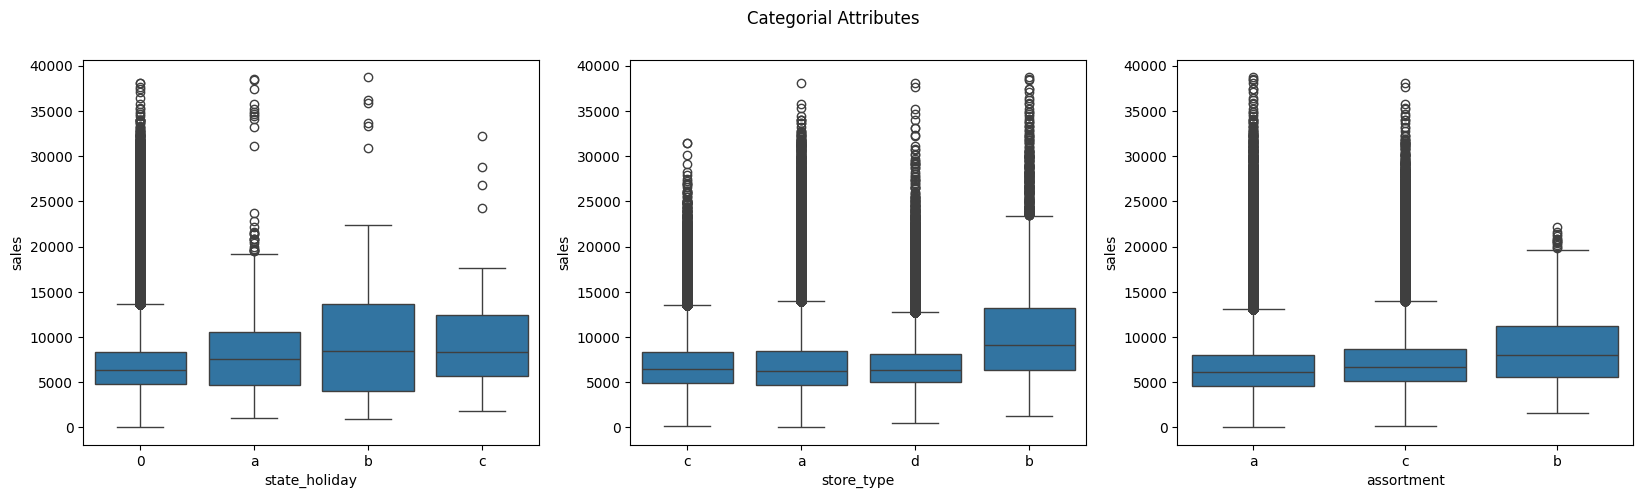

In [16]:
df1_aux = df1[ ( df1['state_holiday'] != 0 )  & ( df1['sales'] > 0 ) ]

fig, axes = plt.subplots(1, 3, figsize=(20, 5))
fig.suptitle('Categorial Attributes')

sns.boxplot( ax=axes[0], x='state_holiday', y='sales', data=df1_aux );
sns.boxplot( ax=axes[1], x='store_type',    y='sales', data=df1_aux );
sns.boxplot( ax=axes[2], x='assortment',    y='sales', data=df1_aux );


# 2.0 Feature Engineering

In [17]:
df2 = df1.copy()

## 2.1 Hypothesis Mind Map

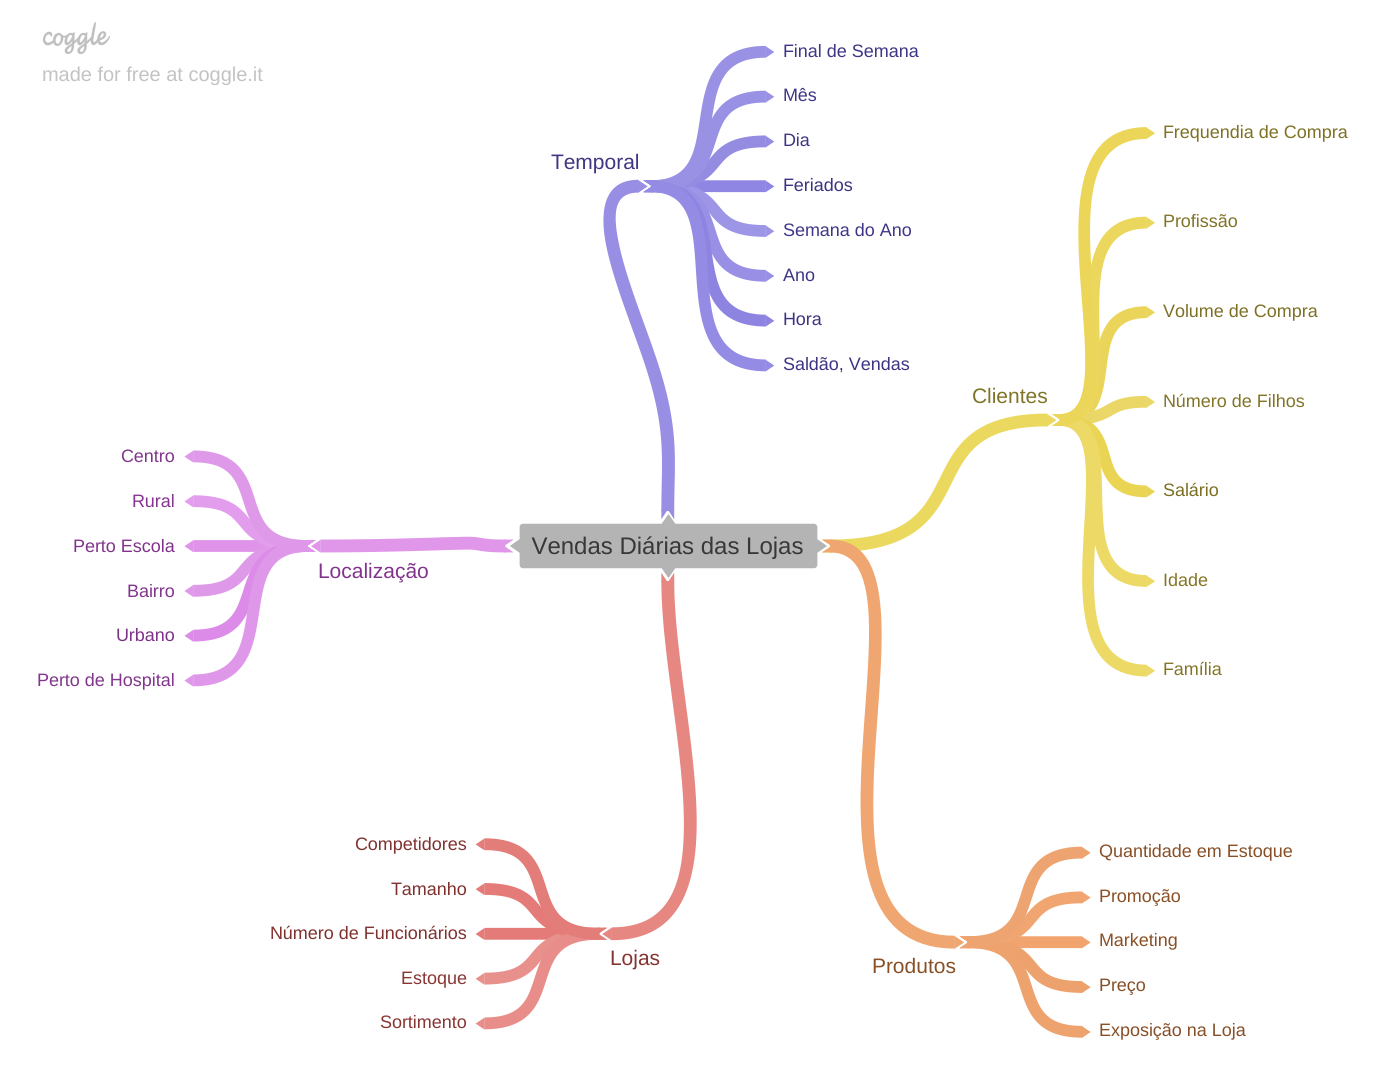

In [18]:
Image( '../img/mapa_de_hipoteses.png')

## 2.2 List of Hypotheses

### 2.2.1 Store Hypothesis

**1.** Lojas com maior número de funcionários deveriam vender mais 

**2.** Lojas com maior estoque deveriam vender mais 

**3.** Lojas de maior porte deveriam vender mais 

**4.** Lojas com maior sortimento deveriam vender mais 

**5.** Lojas com competidores mais próximos deveriam vender menos

**6.** Lojas com competidores a mais tempo deveriam vender mais

### 2.2.2 Product Hypothesis

**1.** Lojas com maior investimento em marketing deveriam vender mais

**2.** Lojas que expõem mais produtos na vitrine deveriam vender mais

**3.** Lojas com produtos com preço menores deveriam vender mais

**4.** Lojas com produtos com preço menores por mais tempo deveriam vender mais

**5.** Lojas com promoções mais agressivas deveriam vender mais

**6.** Lojas com promoções ativas a mais tempo deveriam vender mais

**7.** Lojas com mais dias de promoção deveriam vender mais

**8.** Lojas com mais promoções consecutivas deveriam vender mais

### 2.2.3 Time Hypothesis

**1.** Lojas abertas durante o feriado de Natal deveriam vender mais

**2.** Lojas deveriam vender mais ao longo dos anos

**3.** Lojas deveriam vender mais no segundo semestre do ano

**4.** Lojas deveriam vender mais depois do dia 10 de cada mês

**5.** Lojas deveriam vender menos nos finais de semana

**6.** Lojas deveriam vender menos durante os feriados escolares

## 2.3 Priority List of Hypotheses

**1.** Lojas com maior sortimento deveriam vender mais (STORE)

**2.** Lojas com competidores mais próximos deveriam vender menos (STORE)

**3.** Lojas com competidores a mais tempo deveriam vender mais (STORE)



**4.** Lojas com promoções ativas a mais tempo deveriam vender mais (PRODUCT)

**5.** Lojas com mais dias de promoção deveriam vender mais (PRODUCT)

**6.** Lojas com mais promoções consecutivas deveriam vender mais (PRODUCT)



**7.** Lojas abertas durante o feriado de Natal deveriam vender mais (TIME)

**8.** Lojas deveriam vender mais ao longo dos anos (TIME)

**9.** Lojas deveriam vender mais no segundo semestre do ano (TIME)

**10.** Lojas deveriam vender mais depois do dia 10 de cada mês (TIME)

**11.** Lojas deveriam vender menos nos finais de semana (TIME)

**12.** Lojas deveriam vender menos durante os feriados escolares (TIME)




## 2.4 Create Features

In [19]:
df2 = create_features( df2 )

### 2.4.1 From date column

In [20]:
df2[['date', 'year', 'month', 'day', 'week_of_year', 'year_week']].sample(5)

,date,year,month,day,week_of_year,year_week
812643,2013-07-03,2013,7,3,27,2013-27
810816,2013-07-05,2013,7,5,27,2013-27
67123,2015-06-01,2015,6,1,23,2015-23
371983,2014-08-08,2014,8,8,32,2014-32
731842,2013-09-13,2013,9,13,37,2013-37


### 2.4.2 From competition_open_since columns

In [21]:
df2[['date', 'competition_open_since_year', 'competition_open_since_month', 'competition_since', 'competition_time_month']].sample(5)

,date,competition_open_since_year,competition_open_since_month,competition_since,competition_time_month
826793,2013-06-20,2014,9,2014-09-01,-15
725896,2013-09-19,2006,3,2006-03-01,91
792249,2013-07-21,2014,7,2014-07-01,-12
987064,2013-01-28,2013,10,2013-10-01,-9
452185,2014-05-22,2011,9,2011-09-01,33


### 2.4.3 From promo2_since columns

In [22]:
df2[['promo2_since_year', 'promo2_since_week', 'promo2_since', 'date', 'promo2_time_week']].sample(5)

,promo2_since_year,promo2_since_week,promo2_since,date,promo2_time_week
916208,2013,14,2013-04-01,2013-04-01,0
305688,2012,48,2012-11-19,2014-10-18,99
736591,2013,37,2013-09-09,2013-09-09,0
1005627,2013,2,2013-01-07,2013-01-11,0
836255,2013,24,2013-06-10,2013-06-12,0


### 2.4.4 From assorment column

In [23]:
df2['assortment'].value_counts()

assortment
basic       512539
extended    449924
extra         7916
Name: count, dtype: int64

### 2.4.5 From state_holiday column

In [24]:
df2['state_holiday'].value_counts()

state_holiday
regular day       939329
public holiday     20260
easter holiday      6690
christmas           4100
Name: count, dtype: int64

## 2.5 Filtering Variables

### 2.5.1 Filtering Lines

In [25]:
df2 = remove_rows( df2 )
df2[ ( df2['sales'] == 0 ) | ( df2['open'] == 0 ) ].head()

,store,day_of_week,date,sales,customers,open,promo,state_holiday,school_holiday,store_type,...,is_promo,year,month,day,week_of_year,year_week,competition_since,competition_time_month,promo2_since,promo2_time_week


### 2.5.2 Filtering Columns

In [26]:
df2 = drop_cols( df2 )
df2.columns

Index(['store', 'day_of_week', 'date', 'sales', 'promo', 'state_holiday',
       'school_holiday', 'store_type', 'assortment', 'competition_distance',
       'competition_open_since_month', 'competition_open_since_year', 'promo2',
       'promo2_since_week', 'promo2_since_year', 'is_promo', 'year', 'month',
       'day', 'week_of_year', 'year_week', 'competition_since',
       'competition_time_month', 'promo2_since', 'promo2_time_week'],
      dtype='object')

# 3.0 Exploratory Data Analysis

In [27]:
df3 = df2.copy()

## 3.1 Univariate Analysis

### 3.1.1 Response Variable

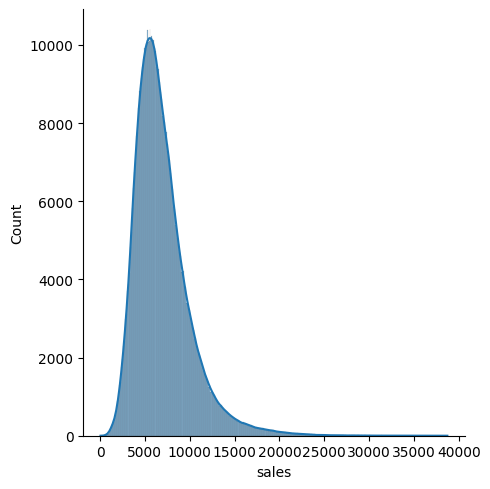

In [28]:
# checking distribuition 
sns.displot( df3['sales'], kde='hist');

### 3.1.2 Numerical Variables

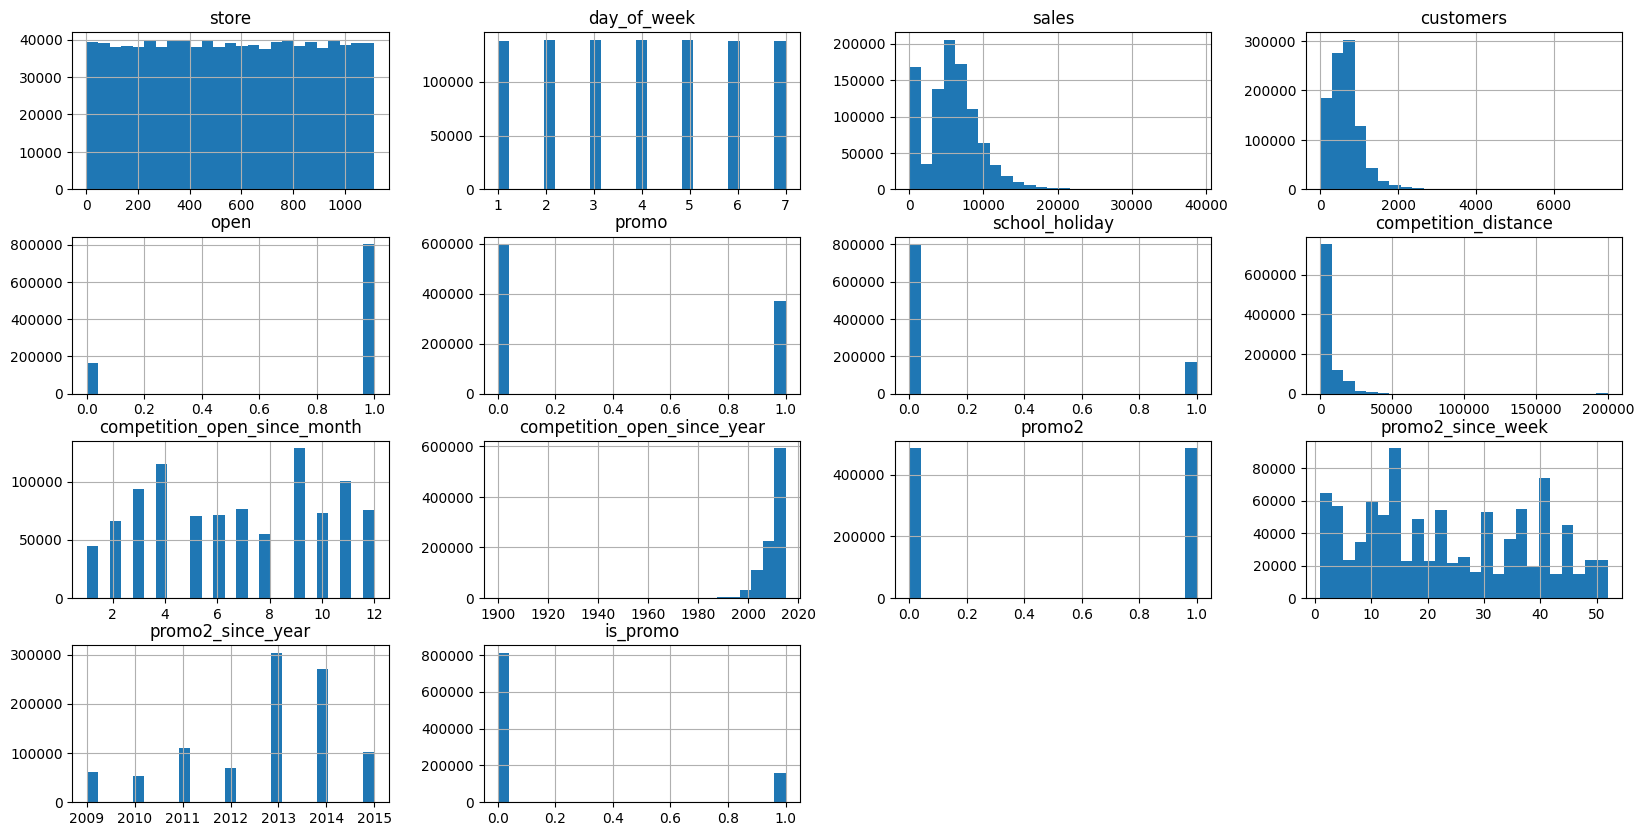

In [29]:
# cheking distribuition
df_num_attributes.hist( bins=25, figsize=(20, 10) );

##### Notas do gráfico: 

**1.** A variável "competition_open_since_month" apresenta vários comportamentos, e quantos mais comportamentos uma variável possui melhor para o aprendizado do modelo.

**2.** Já a variável "day_of_week" apresenta um comportamente constante, não há variação, esse tipo de variável sozinha não serve para o aprendizado modelo

### 3.1.3 Categorical Variables

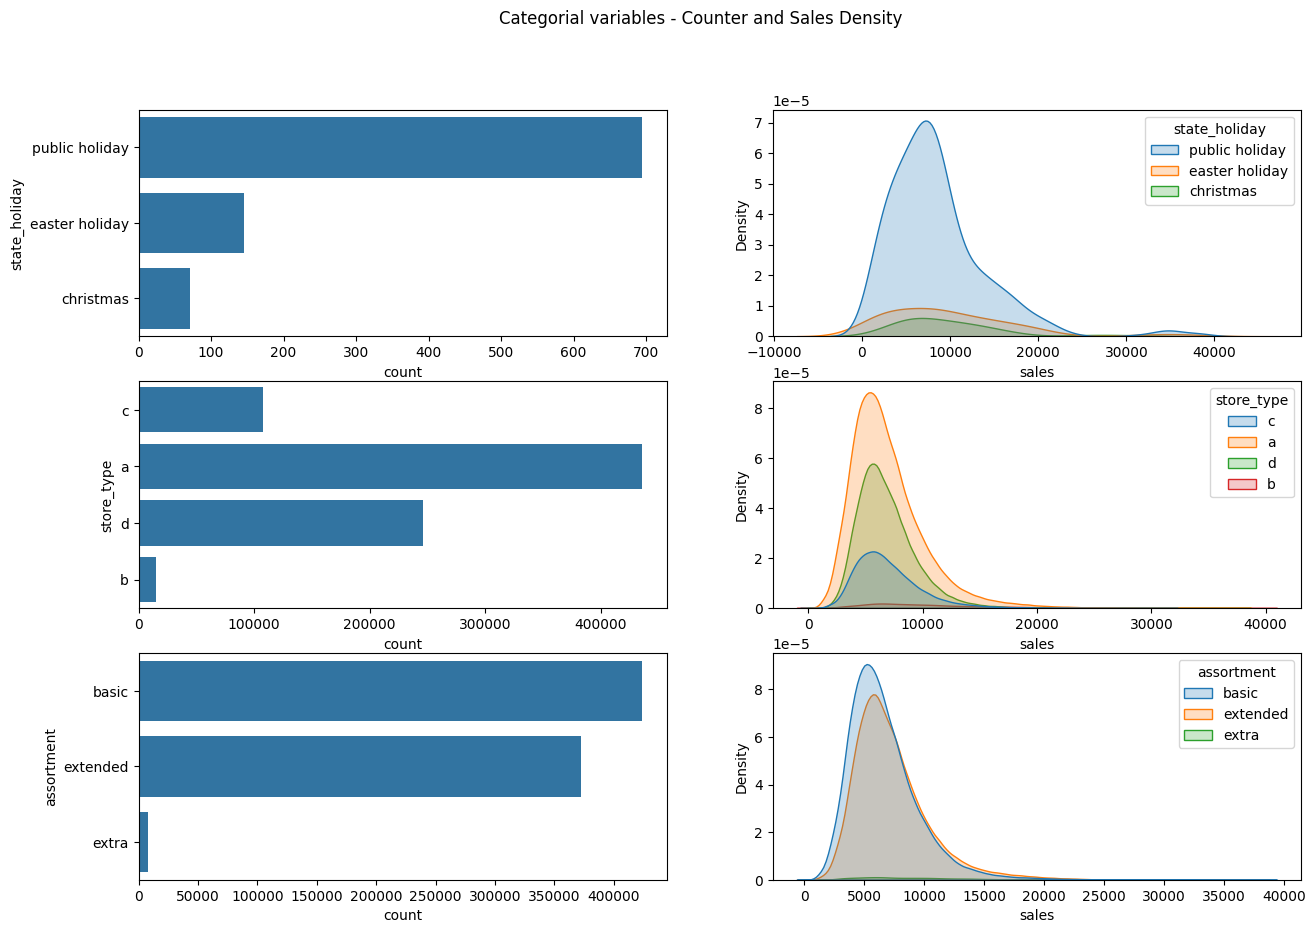

In [30]:
fig, axes = plt.subplots(3, 2, figsize=(15, 10))
fig.suptitle('Categorial variables - Counter and Sales Density')

# state_holiday
sns.countplot( ax=axes[0,0], data=df3[ df3['state_holiday'] !=  'regular day' ]['state_holiday'] );
sns.kdeplot  ( ax=axes[0,1], data=df3[ df3['state_holiday'] !=  'regular day' ][['state_holiday', 'sales']], x='sales',  hue='state_holiday', fill=True );

# store_type
sns.countplot( ax=axes[1,0], data=df3['store_type'] );
sns.kdeplot  ( ax=axes[1,1], data=df3[['store_type', 'sales']], x='sales',  hue='store_type', fill=True );

# assortment
sns.countplot( ax=axes[2,0], data=df3['assortment'] );
sns.kdeplot  ( ax=axes[2,1], data=df3[['assortment', 'sales']], x='sales',  hue='assortment', fill=True );


## 3.2 Bivariate Analysis

### H1 - Lojas com maior sortimento deveriam vender mais (STORE)

***FALSA*** Lojas com MAIOR SORTIMENTO vendem MENOS

***ASSORTMENT*** Apresenta comportamento variável na classe "extra", mas com um volume pequeno de dados, portanto, relevância BAIXA para o modelo

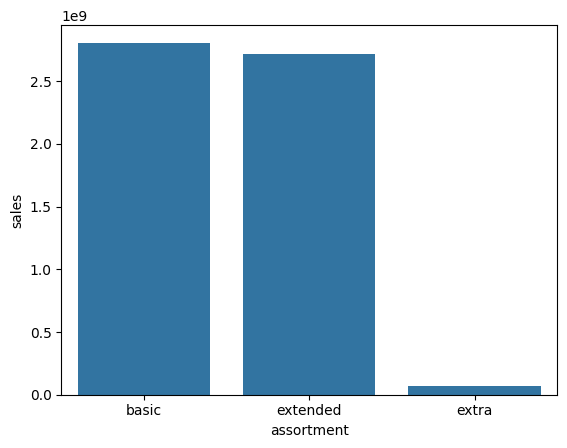

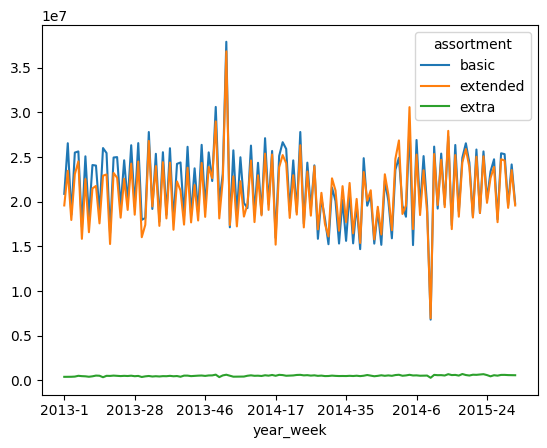

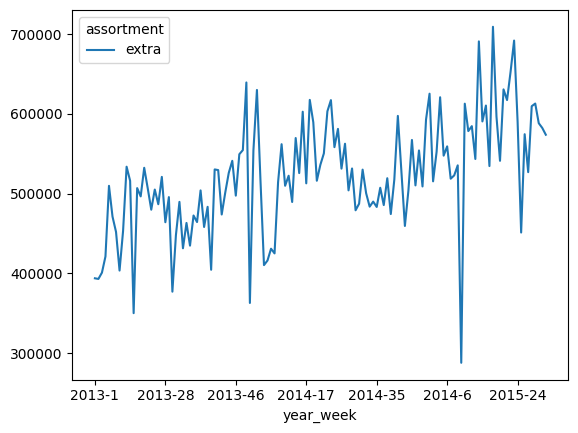

In [31]:
# sales x assortments - total
aux = df3[['assortment', 'sales']].groupby( 'assortment' ).sum().reset_index()
sns.barplot( x='assortment', y='sales', data=aux );

# sales x assortments - timeline 
aux2 = df3[['year_week', 'assortment', 'sales']].groupby( ['year_week', 'assortment'] ).sum().reset_index()
aux2.pivot( index='year_week', columns='assortment', values='sales' ).plot();

# sales x assortments - only "extra" assortment
aux3 = aux2[ aux2['assortment'] == 'extra']
aux3.pivot( index='year_week', columns='assortment', values='sales' ).plot();


### H2 - Lojas com competidores mais próximos deveriam vender menos (STORE)

**FALSA** Lojas com COMPETIDORES MAIS PRÓXIMOS vendem MAIS

**COMPETITION_DISTANCE** apresenta uma correlação FRACA com a variável resposta

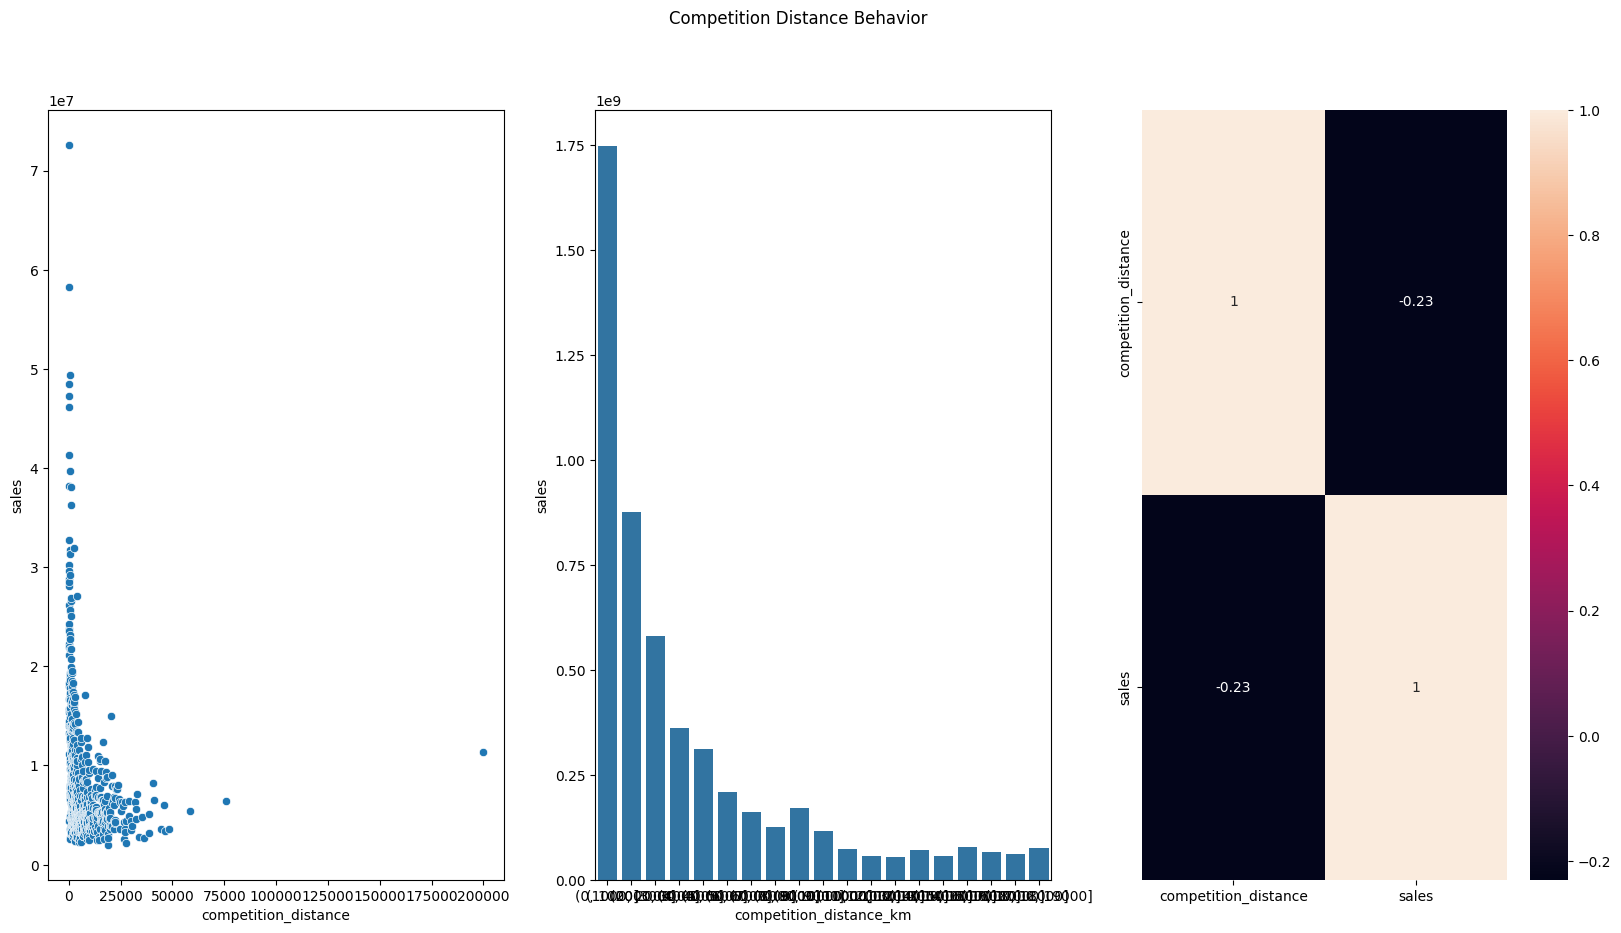

In [32]:

fig, axes = plt.subplots(1, 3, figsize=(20, 10) )
fig.suptitle('Competition Distance Behavior')


# sales x competition_distance - total
aux1 = df3[['competition_distance', 'sales']].groupby( 'competition_distance' ).sum().reset_index()
sns.scatterplot( ax=axes[0], x='competition_distance', y='sales', data=aux1 );


# sales x competition_distance - grouped by km
competition_distance_km = list( np.arange(0, 20000, 1000) )
aux1['competition_distance_km'] = pd.cut( aux1['competition_distance'], bins=competition_distance_km )
aux2 = aux1[['competition_distance_km', 'sales']].groupby( 'competition_distance_km' ).sum().reset_index()
sns.barplot( ax=axes[1], x='competition_distance_km', y='sales', data=aux2 );


# sales x competition_distance corr method
aux3 = aux1[['competition_distance', 'sales']]
sns.heatmap( aux3.corr( method='pearson' ), annot=True, ax=axes[2] );


### H3 - Lojas com competidores a mais tempo deveriam vender mais (STORE)



**FALSA** Lojas com COMPETIDORES A MAIS TEMPO vendem MENOS

**COMPETITION_TIME_MONTH** possui um correlação com a variável resposta muito próxima de ZERO, portanto, BAIXA CORRELAÇÃO

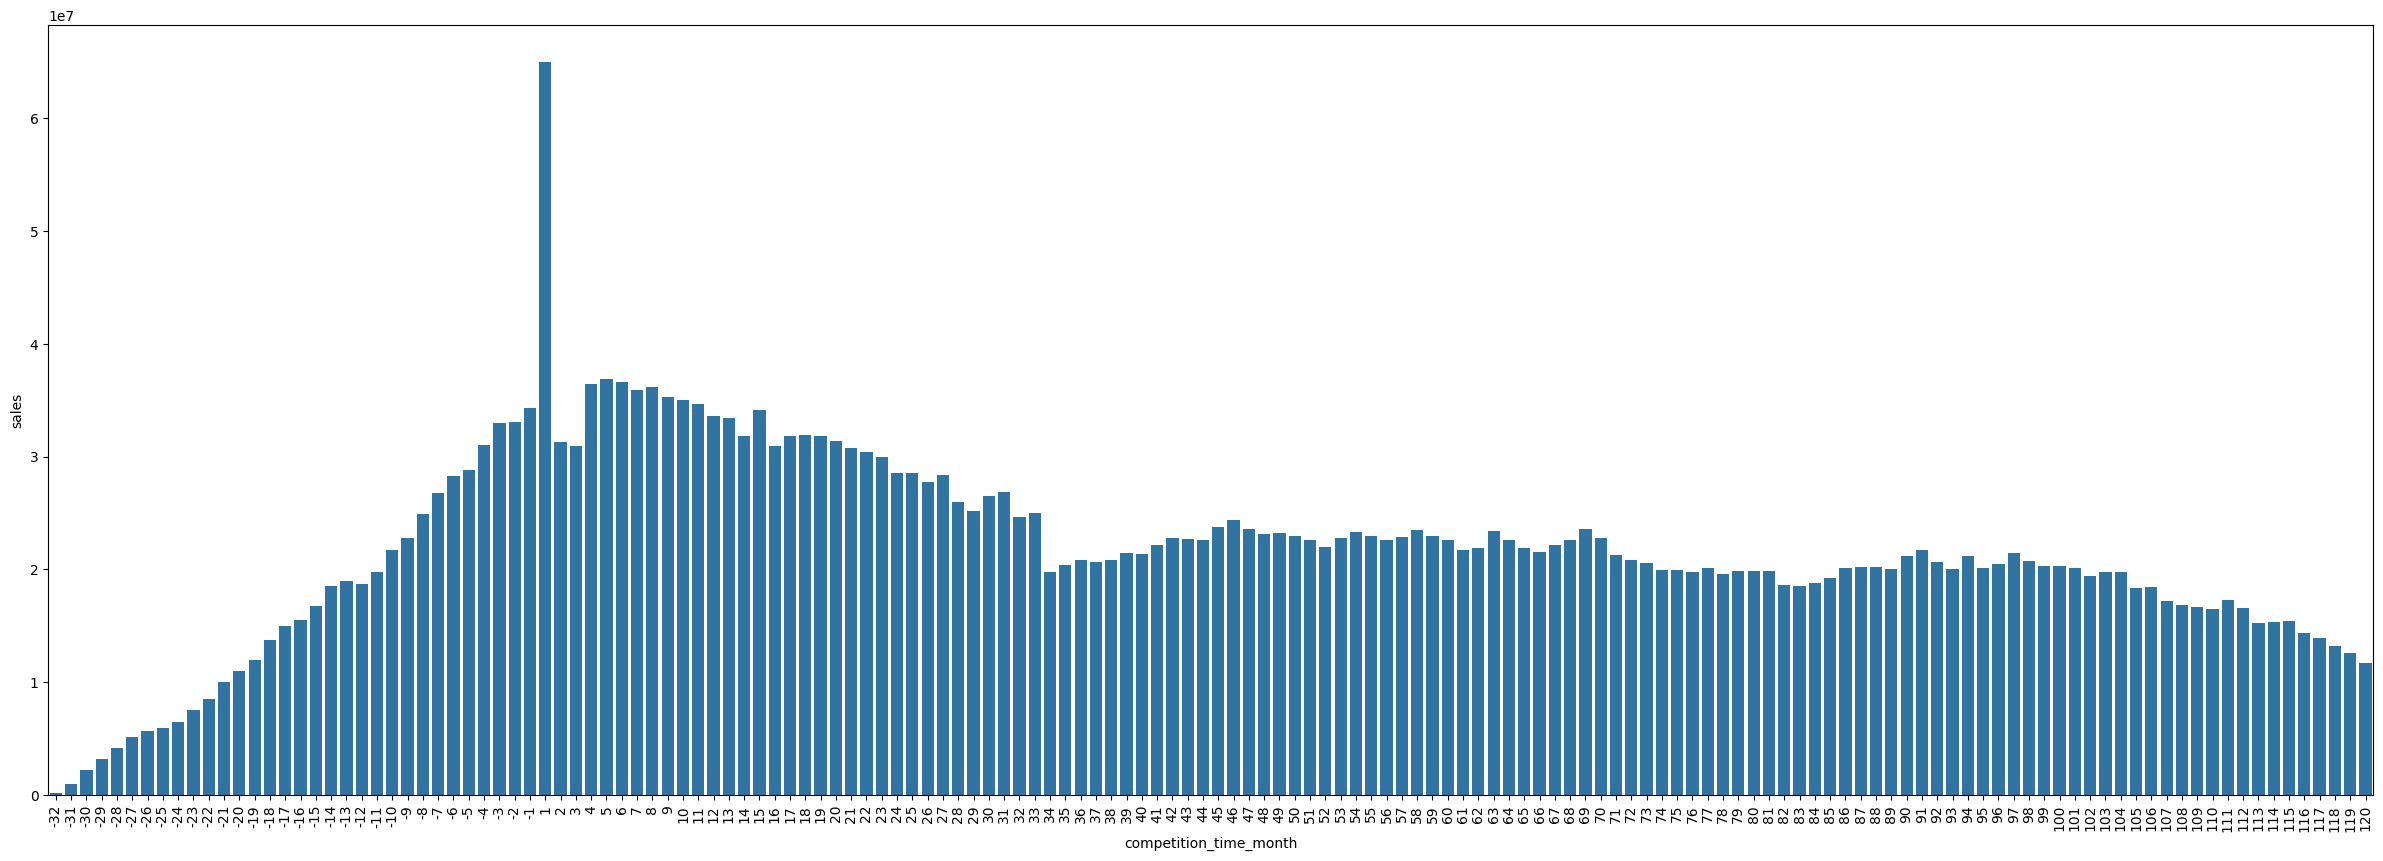

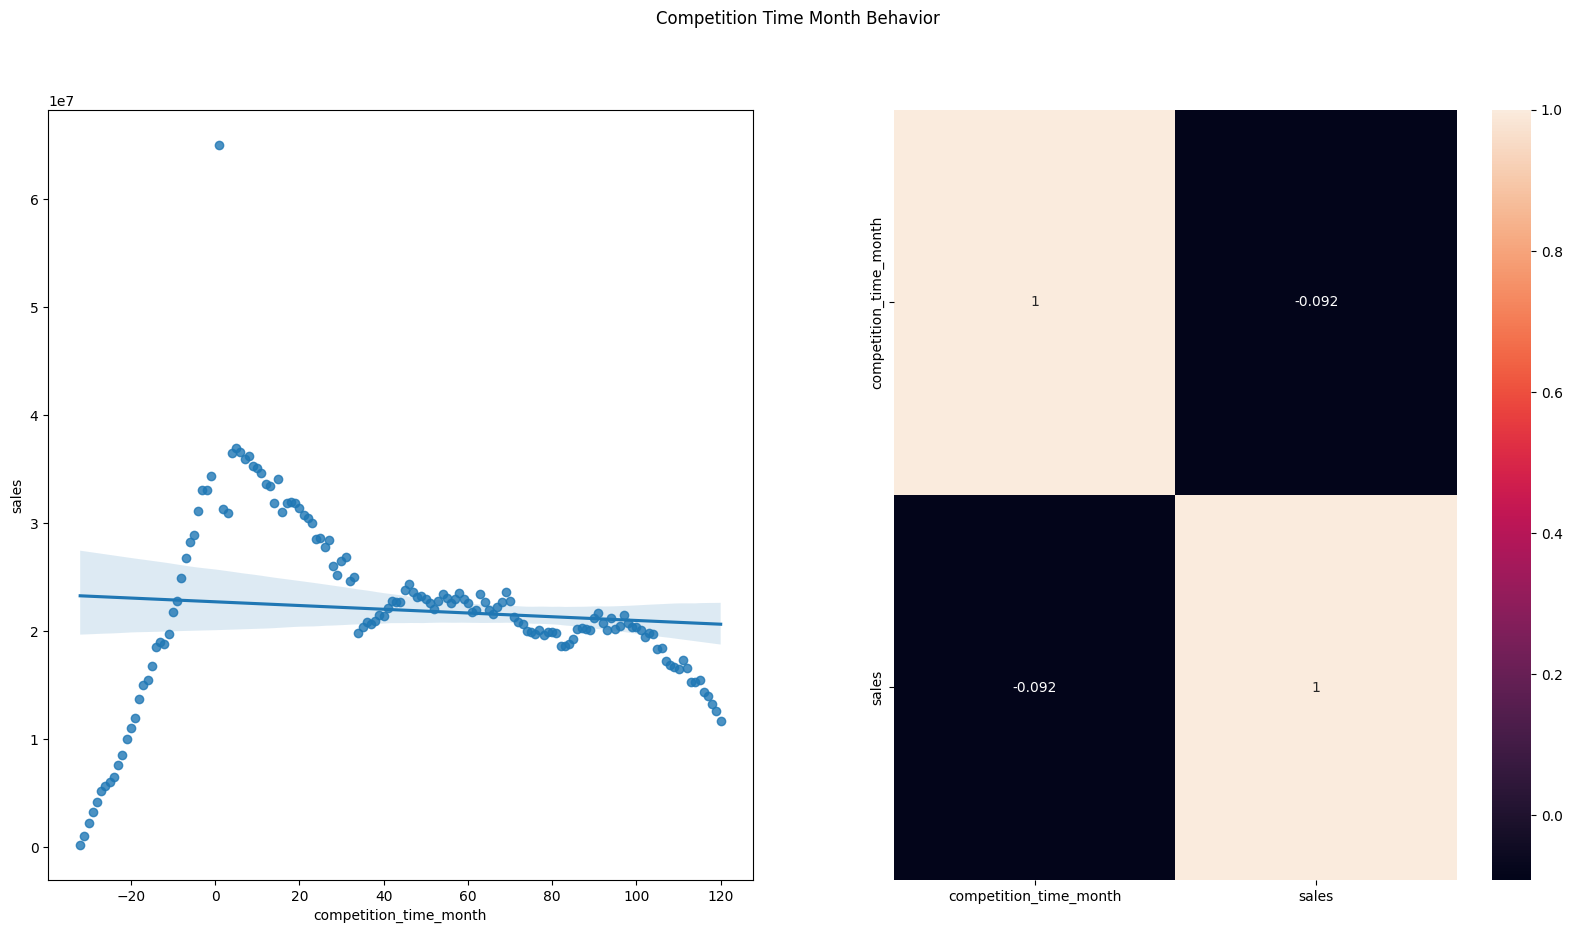

In [33]:
aux1 = df3[['competition_time_month', 'sales']].groupby( 'competition_time_month' ).sum().reset_index()
aux1 = aux1[ ( aux1['competition_time_month'] != 0 ) & ( aux1['competition_time_month'] <= 120 ) ]

plt.figure(figsize=(30,10));
plt.xticks( rotation='vertical');
sns.barplot( x='competition_time_month', y='sales', data=aux1 );

fig, axes = plt.subplots(1, 2, figsize=(20, 10) )
fig.suptitle('Competition Time Month Behavior')

# sales x competition_time_month 
sns.regplot( x='competition_time_month', y='sales', data=aux1, ax=axes[0] );

# sales x competition_distance corr method
sns.heatmap( aux1.corr( method='pearson' ), annot=True, ax=axes[1] );


### H4 - Lojas com promoções ativas a mais tempo deveriam vender mais (PRODUCT)





**FALSA** Lojas com PROMOÇÔES ATIVAS A MAIS TEMPO vendem MENOS depois de um certo período de promoção

**PROMO2_TIME_WEEK** possui uma correlação FRACA com a variável resposta

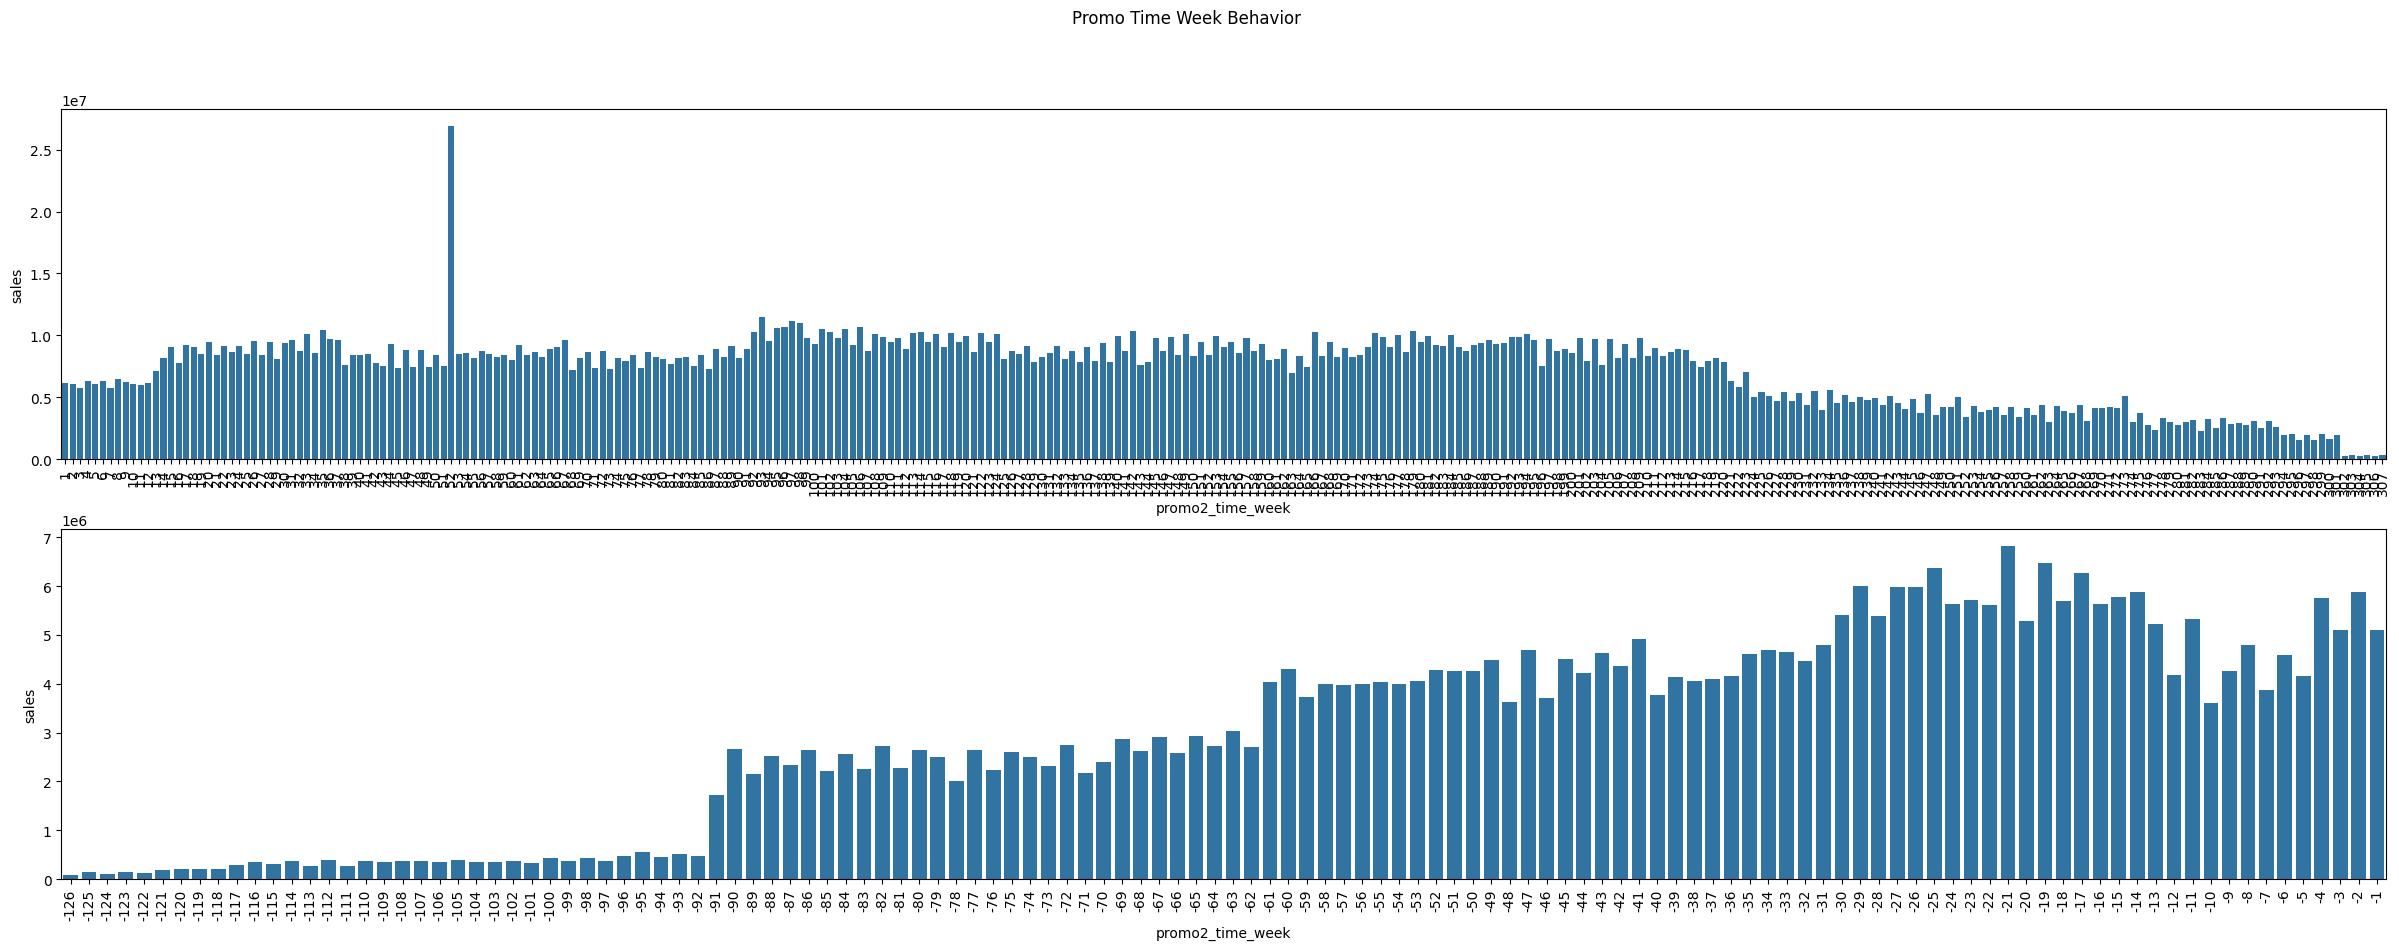

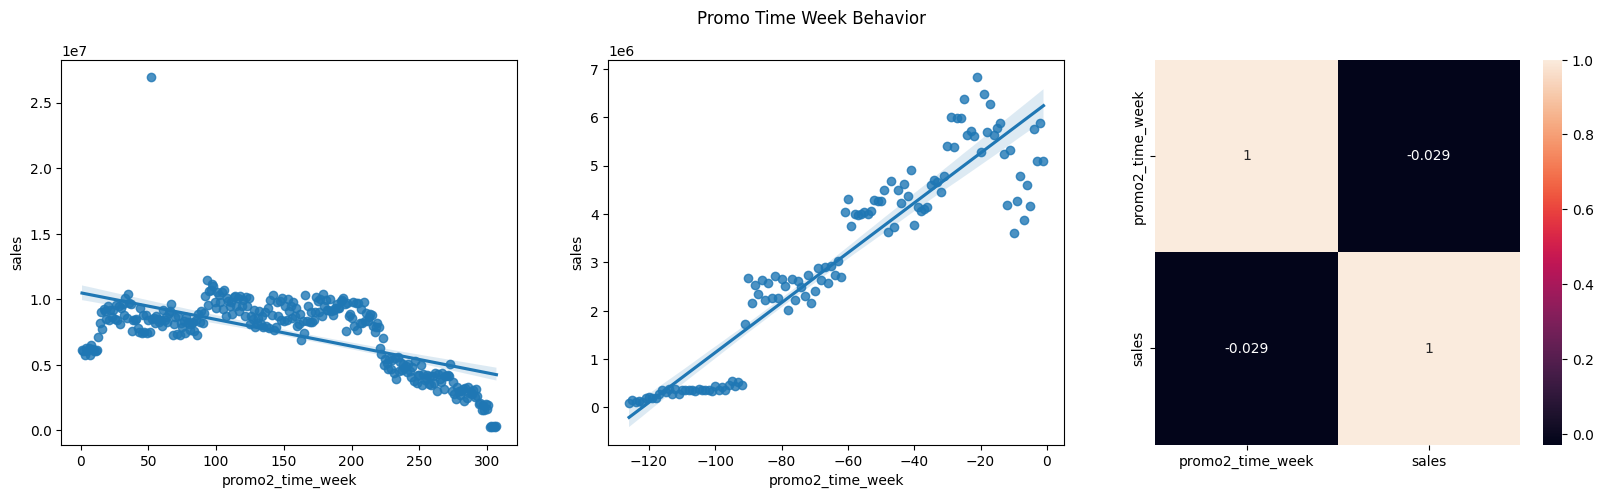

In [34]:
aux1 = df3[['promo2_time_week', 'sales']].groupby( 'promo2_time_week').sum().reset_index()
#sns.barplot( x='promo2_time_week', y='sales', data=aux1 );

# extended promo
aux2 = aux1[ aux1['promo2_time_week'] > 0 ] 

# regular promo
aux3 = aux1[ aux1['promo2_time_week'] < 0 ] 

fig, axes = plt.subplots(2, 1, figsize=(30, 10),  )
fig.suptitle('Promo Time Week Behavior')

axes[0].xaxis.set_tick_params( rotation=90 )
axes[1].xaxis.set_tick_params( rotation=90 )


sns.barplot( x='promo2_time_week', y='sales', data=aux2, ax=axes[0] );
sns.barplot( x='promo2_time_week', y='sales', data=aux3, ax=axes[1] );

fig, axes = plt.subplots(1, 3, figsize=(20, 5) )
fig.suptitle('Promo Time Week Behavior')

sns.regplot( x='promo2_time_week', y='sales', data=aux2, ax=axes[0] );
sns.regplot( x='promo2_time_week', y='sales', data=aux3, ax=axes[1] );
sns.heatmap( aux1.corr( method='pearson'), annot=True, ax=axes[2] );


### <s> H5 - Lojas com mais dias de promoção deveriam vender mais (PRODUCT) </s>

**ON HOLD** Será necessária a criação de uma variável com a quantidade de dias em promoção. Fica para a próxima rodada do CRISP-DS

### H6 - Lojas com mais promoções consecutivas deveriam vender mais (PRODUCT)

**FALSA** Lojas com MAIS PROMOÇÔES CONSECUTIVAS vendem MENOS

**PROMO E PROMO2** aprensentam o mesmo comportamente em relação as vendas, portanto, ambas apresentam um correlação FRACA com a variável resposta

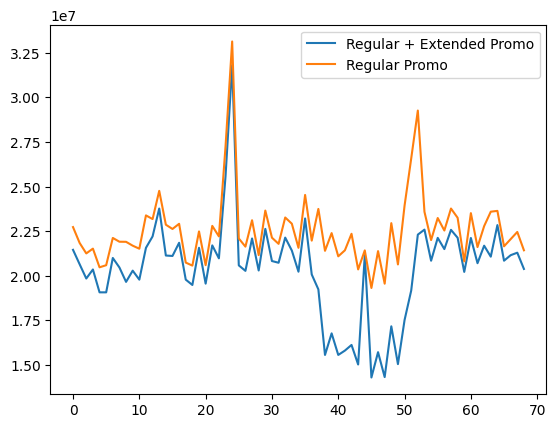

In [35]:
# regular and extended promo
aux1 = df3[ ( df3['promo'] == 1 ) & ( df3['promo2'] == 1 ) ][['year_week', 'sales']].groupby( 'year_week' ).sum().reset_index()
ax = aux1.plot()

# regular promo
aux2 = df3[ ( df3['promo'] == 1 ) & ( df3['promo2'] == 0 ) ][['year_week', 'sales']].groupby( 'year_week' ).sum().reset_index()
aux2.plot( ax=ax )

ax.legend( labels=['Regular + Extended Promo', 'Regular Promo'] );

### H7 -  Lojas abertas durante o feriado de Natal deveriam vender mais (TIME)

**FALSA**, Lojas abertas durante o feriado de Natal vendem MENOS

**STATE_HOLIDAY** possui comportamentos distintos entre os tipos de feriados e por isso ter uma correlação FORTE com a variável resposta

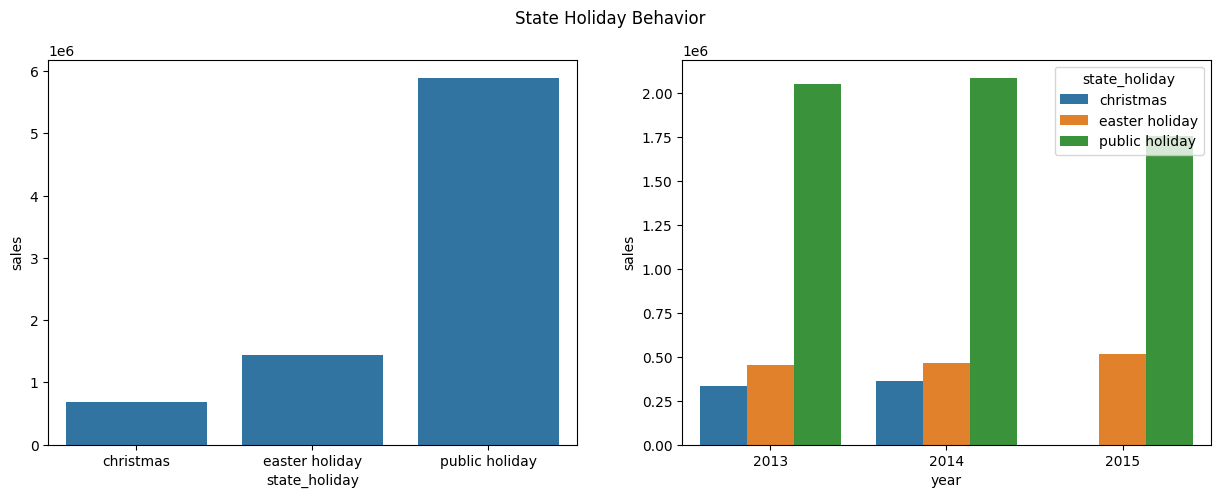

In [36]:
aux1 = df3[ df3['state_holiday'] != 'regular day'][['state_holiday', 'sales']].groupby( 'state_holiday' ).sum().reset_index()
aux2 = df3[ df3['state_holiday'] != 'regular day'][['year', 'state_holiday', 'sales']].groupby( ['year', 'state_holiday'] ).sum().reset_index()

fig, axes = plt.subplots(1, 2, figsize=(15, 5) )
fig.suptitle('State Holiday Behavior')

sns.barplot( x='state_holiday', y='sales', data=aux1, ax=axes[0] );
sns.barplot( x='year', y='sales', hue='state_holiday', data=aux2, ax=axes[1] );



### H8 - Lojas deveriam vender mais ao longo dos anos (TIME)

**FALSA** Lojas vendem MENOS ao longo dos anos

**YEAR** Possui uma correlação FORTE com a variável resposta

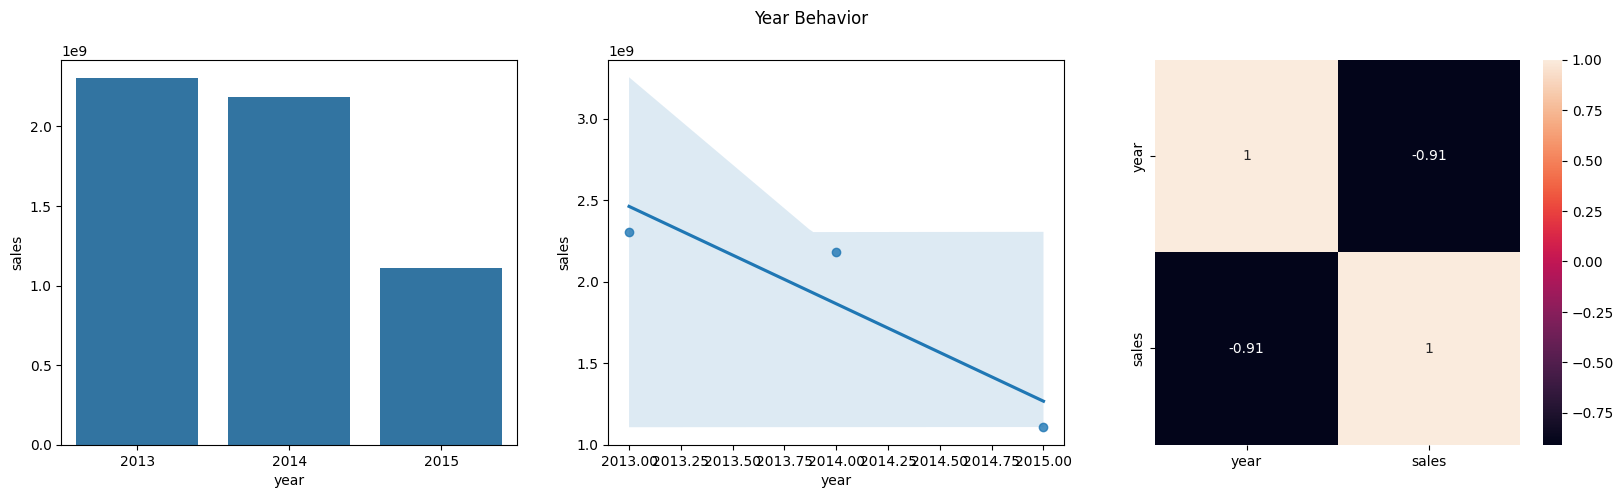

In [37]:
aux1 = df3[['year', 'sales']].groupby( 'year' ).sum().reset_index()

fig, axes = plt.subplots(1, 3, figsize=(20, 5) )
fig.suptitle('Year Behavior')

sns.barplot( x='year', y='sales', data=aux1, ax=axes[0] );
sns.regplot( x='year', y='sales', data=aux1, ax=axes[1] );
sns.heatmap( aux1.corr( method='pearson'), annot=True, ax=axes[2] );


### H9 - Lojas deveriam vender mais no segundo semestre do ano (TIME)

**FALSA** Lojas vendem MENOS no segundo semestre do ANO

**MONTH** possui uma ALTA correlação com a variável resposta

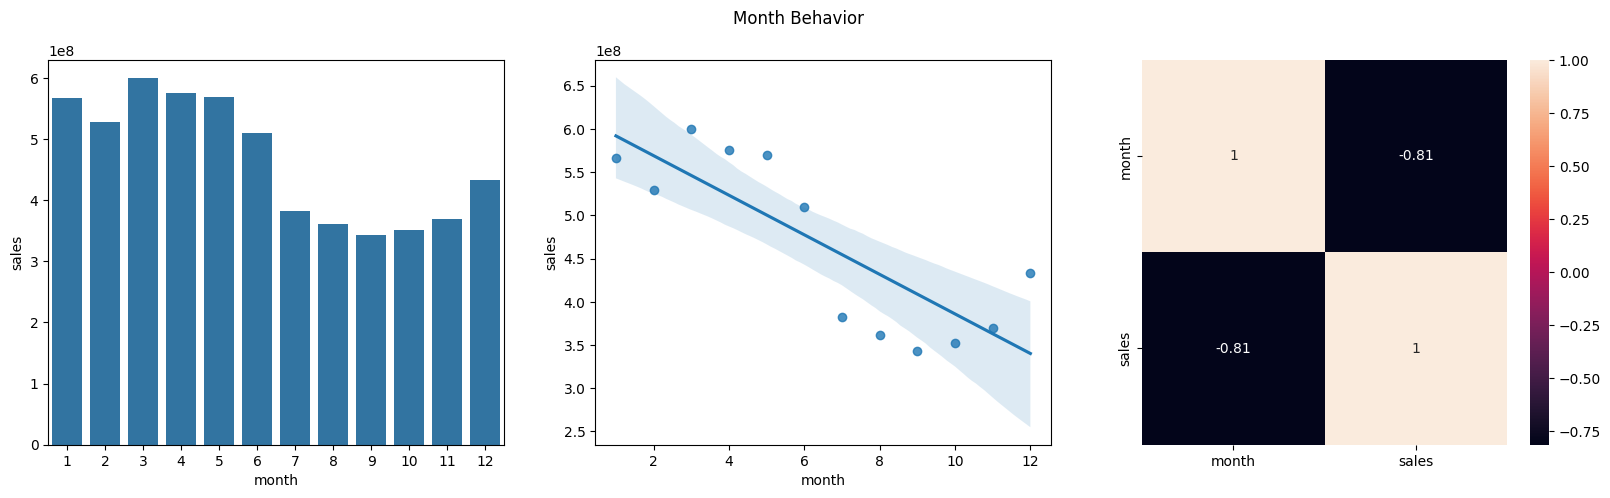

In [38]:
aux1 = df3[['month', 'sales']].groupby( 'month' ).sum().reset_index()

fig, axes = plt.subplots(1, 3, figsize=(20, 5) )
fig.suptitle('Month Behavior')

sns.barplot( x='month', y='sales', data=aux1, ax=axes[0] );
sns.regplot( x='month', y='sales', data=aux1, ax=axes[1] );
sns.heatmap( aux1.corr( method='pearson'), annot=True, ax=axes[2] );

### H10 - Lojas deveriam vender mais depois do dia 10 de cada mês (TIME)

**VERDADEIRA** Lojas vendem MAIS depois do dia 10 de cada mês

**DAY** possui uma correlação MÉDIA com a variável resposta

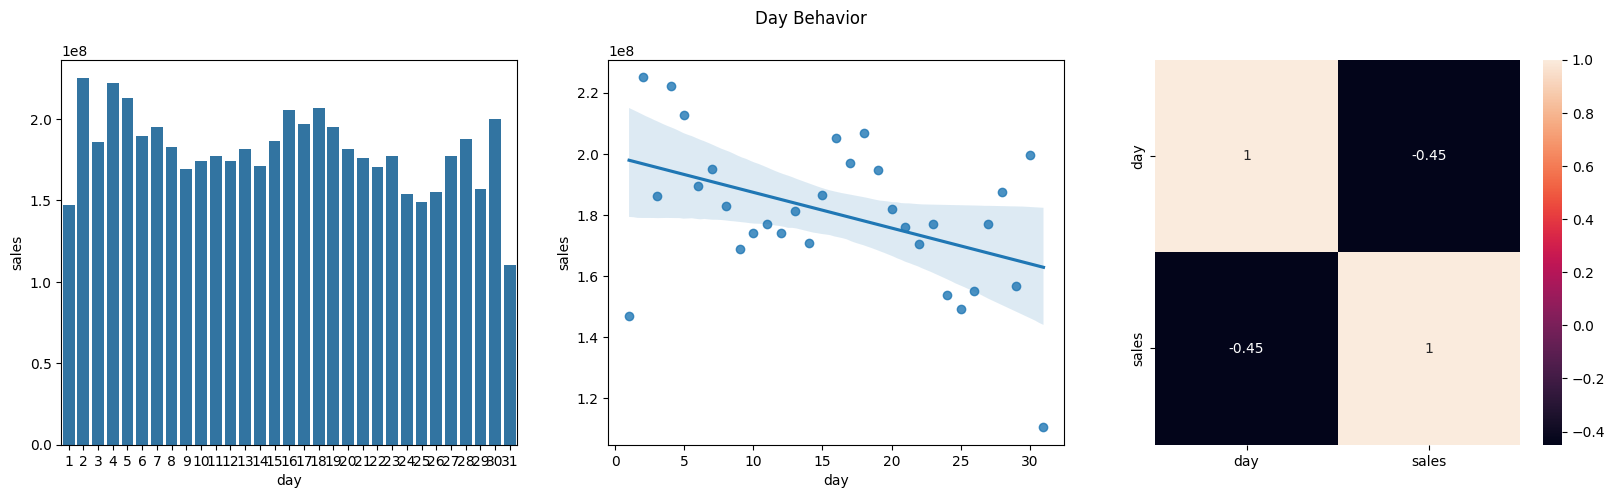

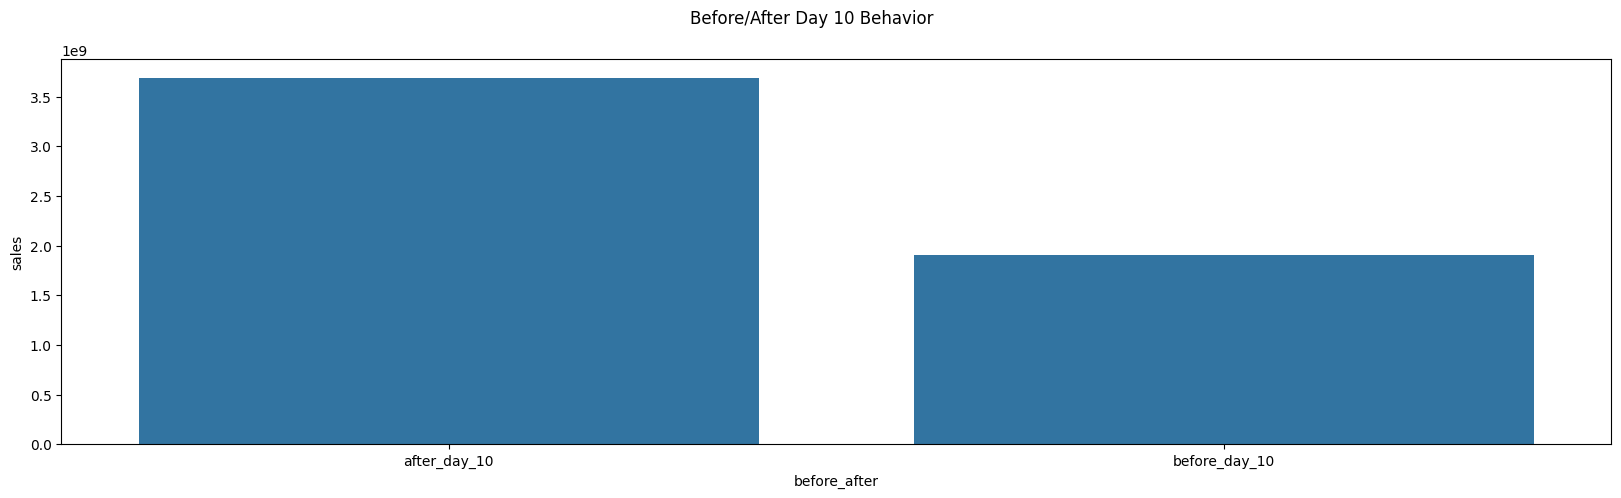

In [39]:
aux1 = df3[['day', 'sales']].groupby( 'day' ).sum().reset_index()

fig, axes = plt.subplots(1, 3, figsize=(20, 5) )
fig.suptitle('Day Behavior')

sns.barplot( x='day', y='sales', data=aux1, ax=axes[0] );
sns.regplot( x='day', y='sales', data=aux1, ax=axes[1] );
sns.heatmap( aux1.corr( method='pearson'), annot=True, ax=axes[2] );

aux1['before_after'] = aux1['day'].apply( lambda x: 'before_day_10' if x <= 10 else 'after_day_10')
aux2 = aux1[['before_after', 'sales']].groupby( 'before_after' ).sum().reset_index()

fig, axes = plt.subplots(1, 1, figsize=(20, 5) )
fig.suptitle('Before/After Day 10 Behavior')

sns.barplot( x='before_after', y='sales', data=aux2 );

### H11 -  Lojas deveriam vender menos nos finais de semana (TIME)

**VERDADEIRA** Lojas vendem MENOS nos finais de semana

**DAY_OF_WEEK** possui uma correlação ALTA com a variável resposta

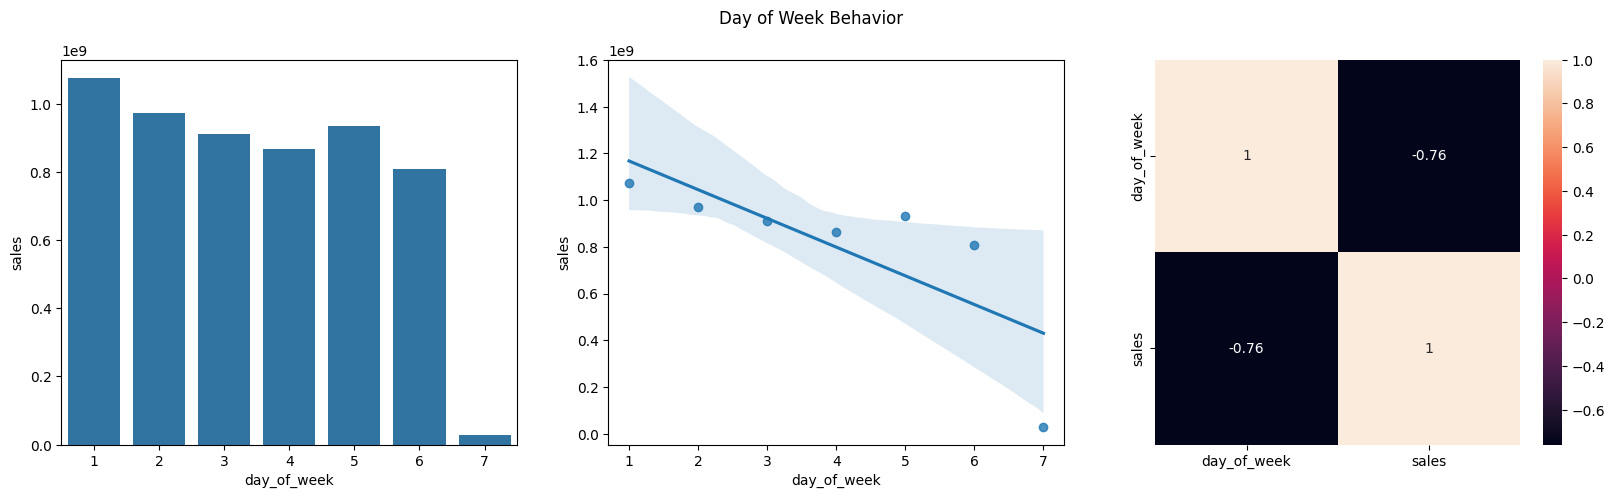

In [40]:
aux1 = df3[['day_of_week', 'sales']].groupby( 'day_of_week' ).sum().reset_index()

fig, axes = plt.subplots(1, 3, figsize=(20, 5) )
fig.suptitle('Day of Week Behavior')

sns.barplot( x='day_of_week', y='sales', data=aux1, ax=axes[0] );
sns.regplot( x='day_of_week', y='sales', data=aux1, ax=axes[1] );
sns.heatmap( aux1.corr( method='pearson'), annot=True, ax=axes[2] );

### H12 - Lojas deveriam vender menos durante os feriados escolares (TIME)

**VERDADEIRA** Lojas vendem MENOS durante  os feriados escolares, exceto mês de agosto

**SCHOOL_HOLIDAY** possui uma correlação ALTA com a variável resposta, no entanto, possui pouca variação de comportamento

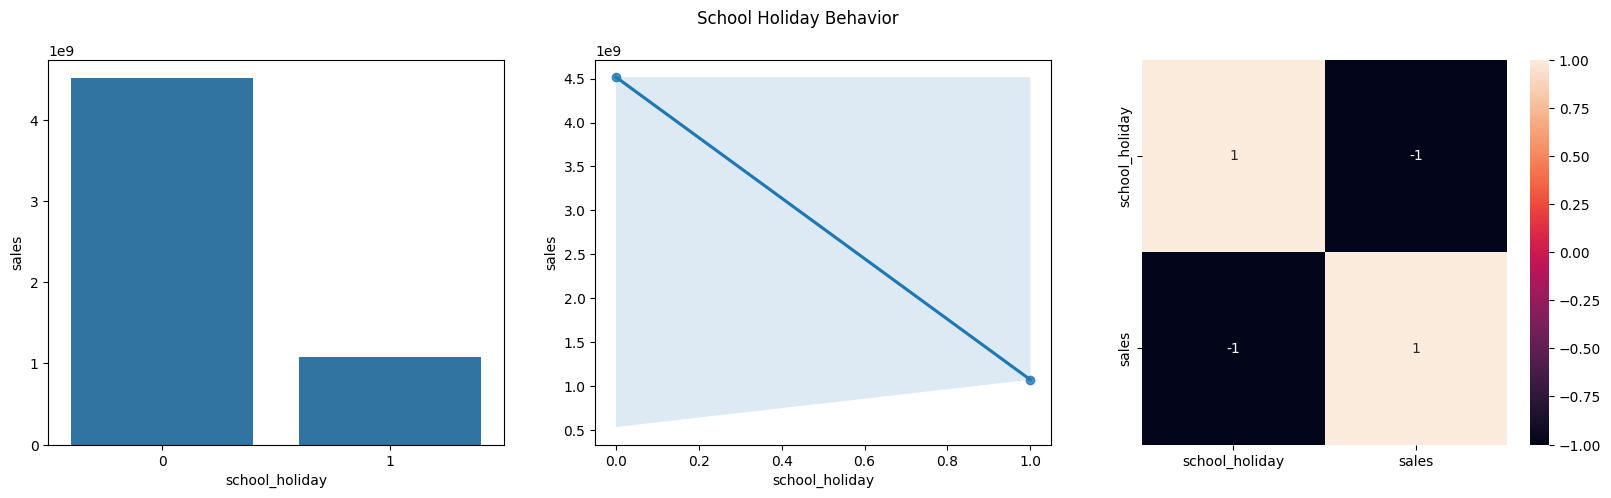

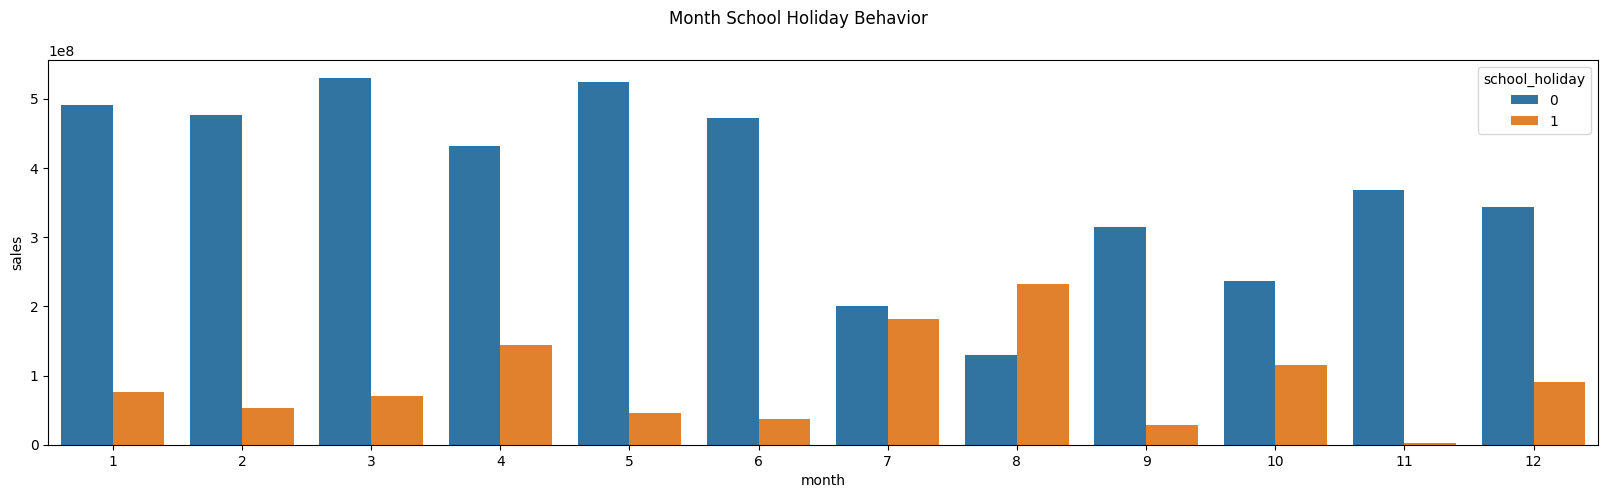

In [41]:
aux1 = df3[['school_holiday', 'sales']].groupby( 'school_holiday' ).sum().reset_index()

fig, axes = plt.subplots(1, 3, figsize=(20, 5) )
fig.suptitle('School Holiday Behavior')

sns.barplot( x='school_holiday', y='sales', data=aux1, ax=axes[0] );
sns.regplot( x='school_holiday', y='sales', data=aux1, ax=axes[1] );
sns.heatmap( aux1.corr( method='pearson'), annot=True, ax=axes[2] );


aux2 = df3[['month', 'school_holiday', 'sales']].groupby( ['month', 'school_holiday'] ).sum().reset_index()

fig, axes = plt.subplots(1, 1, figsize=(20, 5) )
fig.suptitle('Month School Holiday Behavior')

sns.barplot( x='month', hue='school_holiday', y='sales', data=aux2 );

### 3.2.1 Resumo das Hipóteses

In [42]:
tab = [ ['Hipóteses', 'Conclusão', 'Relevância'],
        ['H1', 'Falsa', 'Baixa'],
        ['H2', 'Falsa', 'Baixa'],
        ['H3', 'Falsa', 'Baixa'],
        ['H4', 'Falsa', 'Baixa'],
        ['H5', '-', '-'],
        ['H6', 'Falsa', 'Baixa'],
        ['H7', 'Falsa', 'Alta'],
        ['H8', 'Falsa', 'Alta'],
        ['H9', 'Falsa', 'Alta'],
        ['H10', 'Verdadeira', 'Média'],
        ['H11', 'Verdadeira', 'Alta'],
        ['H12', 'Verdadeira', 'Baixa'],
]

print( tabulate( tab, headers='firstrow' ) )

Hipóteses    Conclusão    Relevância
-----------  -----------  ------------
H1           Falsa        Baixa
H2           Falsa        Baixa
H3           Falsa        Baixa
H4           Falsa        Baixa
H5           -            -
H6           Falsa        Baixa
H7           Falsa        Alta
H8           Falsa        Alta
H9           Falsa        Alta
H10          Verdadeira   Média
H11          Verdadeira   Alta
H12          Verdadeira   Baixa


## 3.3 Multivariate Analysis

### 3.3.1 Numerical Attributes

<Axes: >

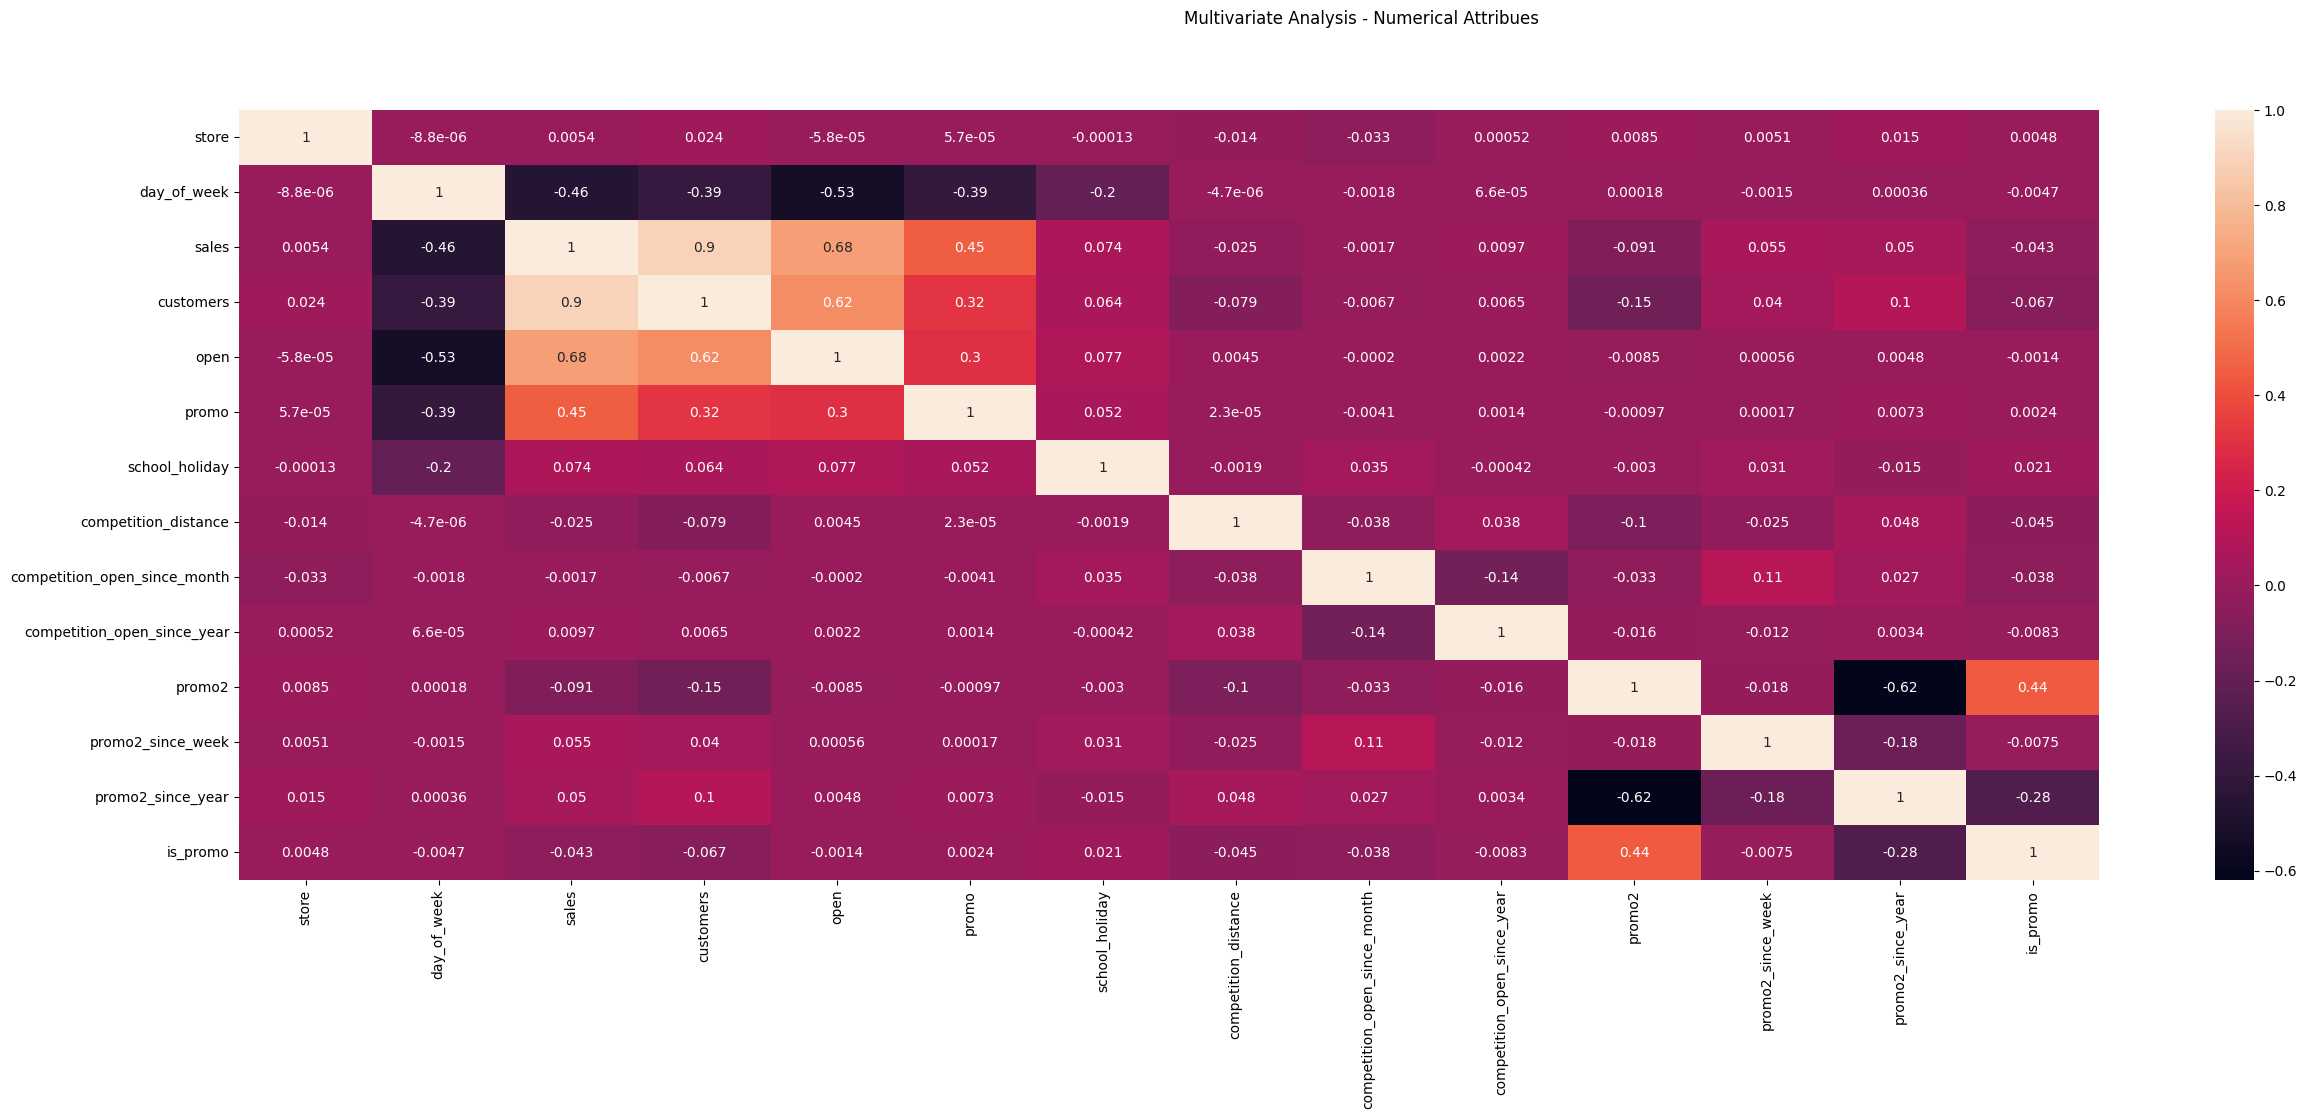

In [43]:
correlation = df_num_attributes.corr( method='pearson' )

fig, axes = plt.subplots(1, 1, figsize=(30, 10) )
fig.suptitle('Multivariate Analysis - Numerical Attribues ')

sns.heatmap( correlation, annot=True )

### 3.3.2 Categorical Attributes

In [44]:
# create a dataframe with new categorical columns
cat = df3.select_dtypes( include='object' )
cat.sample(5)


,state_holiday,store_type,assortment,year_week
895436,regular day,a,extended,2013-16
507894,regular day,a,basic,2014-14
1006557,regular day,a,basic,2013-2
894815,regular day,a,extended,2013-16
670722,regular day,a,extended,2013-45


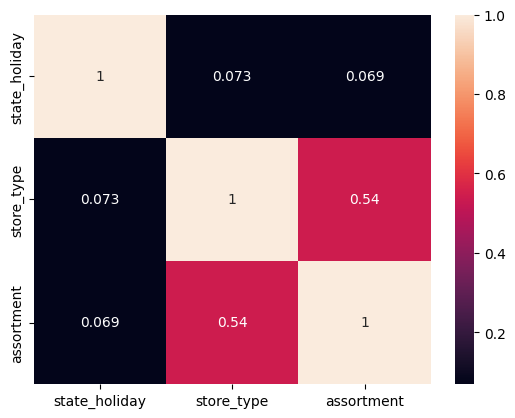

In [45]:
# calculate cramer´s v for all columns combinations 
cv1 = cramer_v( cat['state_holiday'], cat['state_holiday'] )
cv2 = cramer_v( cat['state_holiday'], cat['store_type'] )
cv3 = cramer_v( cat['state_holiday'], cat['assortment'] )

cv4 = cramer_v( cat['store_type'], cat['state_holiday'] )
cv5 = cramer_v( cat['store_type'], cat['store_type'] )
cv6 = cramer_v( cat['store_type'], cat['assortment'] )

cv7 = cramer_v( cat['assortment'], cat['state_holiday'] )
cv8 = cramer_v( cat['assortment'], cat['store_type'] )
cv9 = cramer_v( cat['assortment'], cat['assortment'] )

# create final dataframe
df = pd.DataFrame( { 'state_holiday' : [cv1, cv2, cv3],
                     'store_type'    : [cv4, cv5, cv6],
                     'assortment'    : [cv7, cv8, cv9],
                    })
df = df.set_index( df.columns )

# plot correlations between categorical attributes
sns.heatmap( df, annot=True);

# 4.0 Data Preparation

In [46]:
df4 = df3.copy()

## 4.1 Normalization Method

**COMENTÁRIO:** Ao observar a distribuição das variáveis numéricas (seção 3.1.2), nota-se que NÃO HÁ variáveis com distribuição NORMAL, portanto, não há sentido em executar o método de normalização nesse conjunto de dados

## 4.2 Rescaling Method

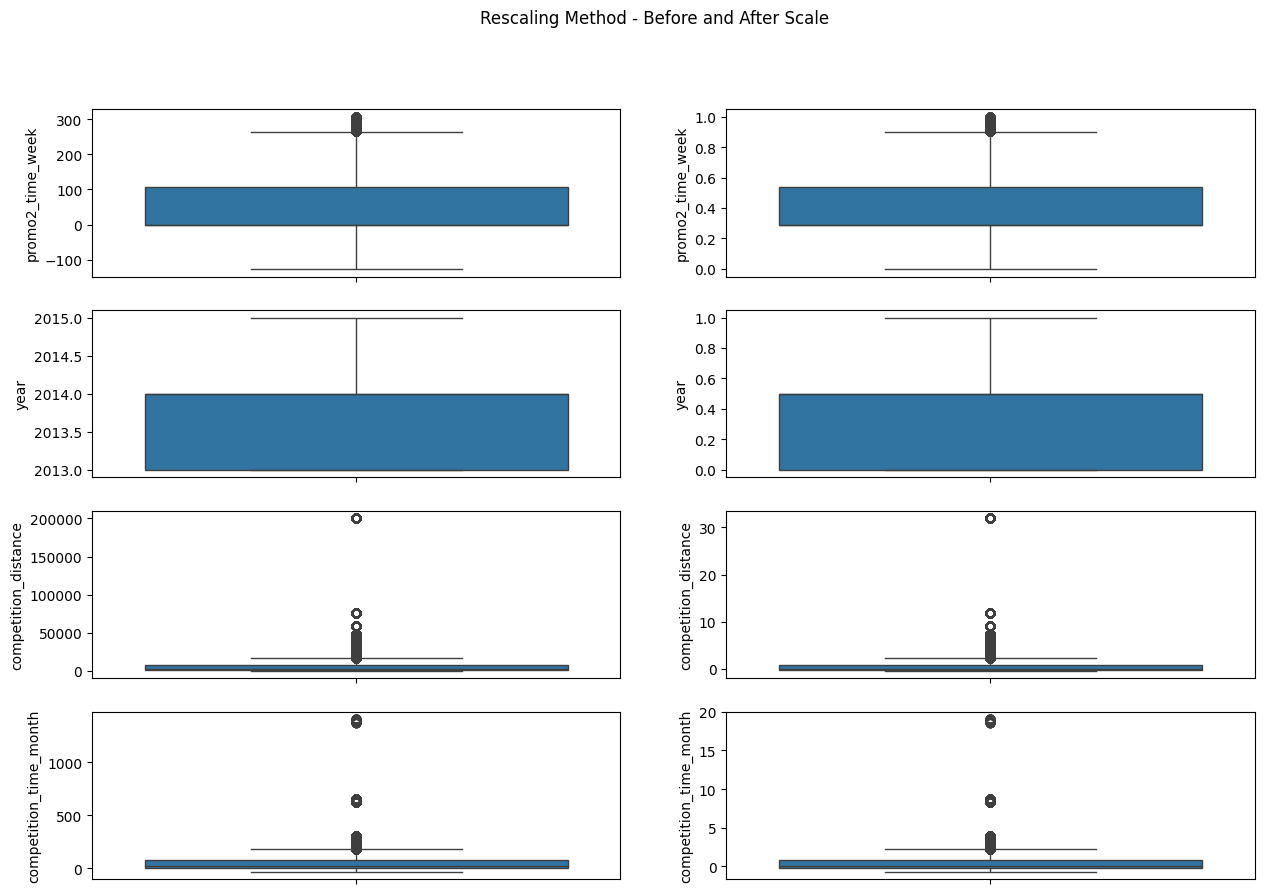

In [47]:
aux = df4[['date', 'sales', 'promo2_time_week', 'year', 'competition_distance', 'competition_time_month']]
df4 = rescaling_features( df4, 'train' )

fig, axes = plt.subplots(4, 2, figsize=(15, 10))
fig.suptitle('Rescaling Method - Before and After Scale')

# promo2_time_wee - Few outliers - MinMax Scaler
sns.boxplot( aux['promo2_time_week'], ax=axes[0,0] );
sns.boxplot( df4['promo2_time_week'], ax=axes[0,1] );

# year - Few outilies - MinMax Scaler
sns.boxplot( aux['year'], ax=axes[1,0] );
sns.boxplot( df4['year'], ax=axes[1,1] );

# competition_distance - Many outliers - Robuster Scaler
sns.boxplot( aux['competition_distance'], ax=axes[2,0] );
sns.boxplot( df4['competition_distance'], ax=axes[2,1] );

# competition_time_month - Many outliers - Robuster Scaler
sns.boxplot( aux['competition_time_month'], ax=axes[3,0] );
sns.boxplot( df4['competition_time_month'], ax=axes[3,1] );


## 4.3 Transformation Method

In [48]:
df4 = encoding_features( df4, 'train' )

### 4.3.1 Encoding Transformation for Categorical Features

In [49]:
# state holiday column - One Hot Encoding
df4[['state_holiday_public holiday', 'state_holiday_regular day', 'state_holiday_easter holiday', 'state_holiday_christmas']]


,state_holiday_public holiday,state_holiday_regular day,state_holiday_easter holiday,state_holiday_christmas
46830,False,True,False,False
46831,False,True,False,False
46832,False,True,False,False
46833,False,True,False,False
46834,False,True,False,False
...,...,...,...,...
1016776,True,False,False,False
1016827,True,False,False,False
1016863,True,False,False,False
1017042,True,False,False,False


In [50]:
# store type column - Label encoding
df4[['store', 'date', 'store_type']]

,store,date,store_type
46830,1,2015-06-19,2
46831,2,2015-06-19,0
46832,3,2015-06-19,0
46833,4,2015-06-19,2
46834,5,2015-06-19,0
...,...,...,...
1016776,682,2013-01-01,1
1016827,733,2013-01-01,1
1016863,769,2013-01-01,1
1017042,948,2013-01-01,1


In [51]:
# assortment column - Ordinal encoding
df4[['store', 'date', 'assortment']]

,store,date,assortment
46830,1,2015-06-19,1
46831,2,2015-06-19,1
46832,3,2015-06-19,1
46833,4,2015-06-19,3
46834,5,2015-06-19,1
...,...,...,...
1016776,682,2013-01-01,1
1016827,733,2013-01-01,2
1016863,769,2013-01-01,2
1017042,948,2013-01-01,2


### 4.3.2 Response Variable Magnitude Transformation 

In [52]:
aux = df4[['date', 'sales']]

df4 = magnitude_features( df4 )

aux['new_sales'] = df4['sales']
aux.sample(5)


,date,sales,new_sales
809770,2013-07-06,9607,9.170351
182062,2015-02-18,7603,8.936430
420074,2014-06-20,6660,8.804025
591708,2014-01-17,5050,8.527342
657918,2013-11-19,9630,9.172742


### 4.3.3 Nature Transformation - Variables with cyclical behavior

In [53]:
df4 = ciclyc_features( df4 )

In [54]:
# month
df4[['month', 'month_sin', 'month_cos']].sample(5)

,month,month_sin,month_cos
522316,3,1.000000,6.123234e-17
754231,8,-0.866025,-5.000000e-01
315920,10,-0.866025,5.000000e-01
394083,7,-0.500000,-8.660254e-01
780578,8,-0.866025,-5.000000e-01


In [55]:
# day_of_week
df4[['day_of_week', 'day_of_week_sin', 'day_of_week_cos']].sample(5)

,day_of_week,day_of_week_sin,day_of_week_cos
349985,1,0.781831,0.623490
339954,5,-0.974928,-0.222521
789772,2,0.974928,-0.222521
286062,6,-0.781831,0.623490
510614,1,0.781831,0.623490


In [56]:
# day
df4[['day', 'day_sin', 'day_cos']].sample(5)

,day,day_sin,day_cos
295703,29,-0.207912,0.978148
848635,1,0.207912,0.978148
903760,12,0.587785,-0.809017
881239,2,0.406737,0.913545
789840,23,-0.994522,0.104528


In [57]:
# week_of_year
df4[['week_of_year', 'week_of_year_sin', 'week_of_year_cos']].sample(5)

,week_of_year,week_of_year_sin,week_of_year_cos
615714,52,-2.449294e-16,1.000000
450641,21,5.680647e-01,-0.822984
825884,25,1.205367e-01,-0.992709
891117,17,8.854560e-01,-0.464723
200515,6,6.631227e-01,0.748511


# 5.0 Feature Selection

In [58]:
df5 = df4.copy()

## 5.1 Create Training Dataset

In [59]:
# remove all features that created new features
cols_drop = ['week_of_year', 'month', 'day', 'day_of_week', 'promo2_since', 'competition_since', 'year_week']
df5 = df5.drop( cols_drop, axis=1 )

# create training dataset 
X_train = df5.copy()
y_train = X_train['sales']

## 5.2 Boruta as Feature Selector

In [60]:
# transform training and test as array values to fit Boruta
# X_train_array = X_train.drop( ['date', 'sales'], axis=1 ).values
# y_train_array = y_train.values.ravel()

# define Random Forest Regressor
# rf = RandomForestRegressor( n_jobs=-1)

# define Boruta
# boruta = BorutaPy( rf, n_estimators='auto', verbose=2, random_state=42 ).fit( X_train_array, y_train_array )

## 5.3 Selected and NOT Selected Features by Boruta

In [61]:
# get cols selected and not selected by boruta
# X_train_fs = X_train.drop( ['date', 'sales'], axis=1 )

# best features
# cols_selected = boruta.support_.tolist()
# cols_selected_boruta = X_train_fs.iloc[:, cols_selected].columns.tolist()

# not selected boruta
# cols_not_selected_boruta = list( np.setdiff1d( X_train_fs.columns, cols_selected_boruta ) )

In [62]:
# features selected by boruta
cols_selected_boruta = ['store', 'promo', 'store_type', 'assortment', 'competition_distance', 'competition_open_since_month',
                        'competition_open_since_year', 'promo2', 'promo2_since_week', 'promo2_since_year', 'competition_time_month',
                        'promo2_time_week', 'month_cos', 'day_of_week_sin', 'day_of_week_cos', 'day_sin', 'day_cos', 'week_of_year_cos']
cols_selected_boruta

['store',
 'promo',
 'store_type',
 'assortment',
 'competition_distance',
 'competition_open_since_month',
 'competition_open_since_year',
 'promo2',
 'promo2_since_week',
 'promo2_since_year',
 'competition_time_month',
 'promo2_time_week',
 'month_cos',
 'day_of_week_sin',
 'day_of_week_cos',
 'day_sin',
 'day_cos',
 'week_of_year_cos']

In [63]:
# features NOT selected by boruta
cols_not_selected_boruta = ['is_promo', 'month_sin', 'school_holiday', 'state_holiday_christmas', 'state_holiday_easter holiday',
                            'state_holiday_public holiday', 'state_holiday_regular day', 'week_of_year_sin', 'year']
cols_not_selected_boruta

['is_promo',
 'month_sin',
 'school_holiday',
 'state_holiday_christmas',
 'state_holiday_easter holiday',
 'state_holiday_public holiday',
 'state_holiday_regular day',
 'week_of_year_sin',
 'year']

## 5.4 Final Feature Selection by Me and Boruta

In [64]:
# create a list with all features selected by me and Boruta, add date and sales columns
final_features = cols_selected_boruta.copy()
final_features.extend( ['date', 'sales', 'month_sin', 'week_of_year_sin'] )
final_features

['store',
 'promo',
 'store_type',
 'assortment',
 'competition_distance',
 'competition_open_since_month',
 'competition_open_since_year',
 'promo2',
 'promo2_since_week',
 'promo2_since_year',
 'competition_time_month',
 'promo2_time_week',
 'month_cos',
 'day_of_week_sin',
 'day_of_week_cos',
 'day_sin',
 'day_cos',
 'week_of_year_cos',
 'date',
 'sales',
 'month_sin',
 'week_of_year_sin']

## 5.5 Create Train Dataset with Features to Apply ML Algorithms

In [65]:
# create datasets with final features and csv file
X_train[final_features].to_csv( '../data/train_feat.csv', index=False )

# 6.0 Machine Learning Modelling

In [5]:
X_train = pd.read_csv( '../data/train_feat.csv',  low_memory= False )
X_train['date'] = pd.to_datetime( X_train['date'] )

## 6.1 Split df_feat_train in two datasets: X_train( full ) and X_validation( last 36 weeks )

In [67]:
# calculate period - last 36  weeks
last_date  = X_train[['store', 'date']].groupby( 'store' ).max().reset_index().loc[0, 'date']
first_date = last_date - datetime.timedelta( days=36*7 )

last_date_period = last_date

print(f'First date: {first_date}')
print(f'Last date: {last_date}')

# creating full datasets: X_train e X_validation
X_validation = X_train[ X_train['date'] > first_date ]

# create x_train, y_train variables
x_train = X_train[ X_train['date'] <= first_date ]
y_train = x_train['sales']
x_train = x_train.drop( ['date', 'sales'], axis=1 )

# calculate period - first 6 weeks from validation dataset
first_date = X_validation[['store', 'date']].groupby( 'store' ).min().reset_index().loc[0, 'date']
last_date  = first_date + datetime.timedelta( days=6*7 )

print(f'\nFirst date Validation: {first_date}')
print(f'Last date Validation: {last_date}')

# create x_validation, y_validation variables
x_validation = X_validation[ X_validation['date'] < last_date ]
y_validation = x_validation['sales']
x_validation = x_validation.drop( ['date', 'sales'], axis=1 )

print(f'\n { last_date - first_date }' )

First date: 2014-10-10 00:00:00
Last date: 2015-06-19 00:00:00

First date Validation: 2014-10-11 00:00:00
Last date Validation: 2014-11-22 00:00:00

 42 days 00:00:00


## 6.2 Average Model

In [68]:
# create aux_df with database test + response variable (sales)
aux1          = x_validation.copy()
aux1['sales'] = y_validation.copy()

# prediction
aux2 = aux1[['store', 'sales']].groupby( 'store' ).mean().reset_index().rename( columns = {'sales' :  'sales_predictions' } )
aux1 = pd.merge( aux1, aux2, how='left', on='store' )
yhat_avg = aux1['sales_predictions']

# calculate performance with response variable "sales" on original scale 
avg_model_result = ml_error( 'Average Model', np.expm1( y_validation ), np.expm1( yhat_avg ) )
avg_model_result

,Model Name,MAE,MAPE,RMSE
0,Average Model,1160.150027,NaN,1568.681103


## 6.3 Linear Regression Model

### 6.3.1 Linear Regression - Single Performance

In [69]:
# define model
lr_model = LinearRegression().fit( x_train, y_train )

# create predictions
yhat_lr = lr_model.predict( x_validation )

# calculate performance
lr_model_result = ml_error( 'Linear Regression Model', np.expm1( y_validation ), np.expm1( yhat_lr) )
lr_model_result

,Model Name,MAE,MAPE,RMSE
0,Linear Regression Model,1856.500159,0.313258,2549.678627


### 6.3.2 Linear Regression - Cross Validation

In [70]:
lr_model_result_cv = cross_validation( X_train, 5, 'Linear Regression', lr_model, verbose=True )
lr_model_result_cv


Validation Block: 5. Dates: 2014-11-21 00:00:00 - 2015-01-02 00:00:00

Validation Block: 4. Dates: 2015-01-02 00:00:00 - 2015-02-13 00:00:00

Validation Block: 3. Dates: 2015-02-13 00:00:00 - 2015-03-27 00:00:00

Validation Block: 2. Dates: 2015-03-27 00:00:00 - 2015-05-08 00:00:00

Validation Block: 1. Dates: 2015-05-08 00:00:00 - 2015-06-19 00:00:00


,Model Name,MAE CV,MAPE CV,RMSE CV
0,Linear Regression,2094.58 +/- 307.06,0.3 +/- 0.02,2965.86 +/- 481.91


## 6.4 Liner Regression Regularized (Lasso) - Model

### 6.4.1 Lasso - Single Performance

In [71]:
# define model
lasso_model = Lasso( alpha=0.01 ).fit( x_train, y_train )

# create predictions
yhat_lasso = lasso_model.predict( x_validation )

# calculate performance
lasso_model_result = ml_error( 'Linear Regression Regularized Model - Lasso', np.expm1( y_validation), np.expm1( yhat_lasso) )
lasso_model_result

,Model Name,MAE,MAPE,RMSE
0,Linear Regression Regularized Model - Lasso,1839.005227,0.30353,2573.081173


### 6.4.2 Lasso - Cross Validation

In [72]:
lasso_model_result_cv = cross_validation( X_train, 5, 'Linear Regression Regularized - Lasso', lasso_model, verbose=True )
lasso_model_result_cv


Validation Block: 5. Dates: 2014-11-21 00:00:00 - 2015-01-02 00:00:00

Validation Block: 4. Dates: 2015-01-02 00:00:00 - 2015-02-13 00:00:00

Validation Block: 3. Dates: 2015-02-13 00:00:00 - 2015-03-27 00:00:00

Validation Block: 2. Dates: 2015-03-27 00:00:00 - 2015-05-08 00:00:00

Validation Block: 1. Dates: 2015-05-08 00:00:00 - 2015-06-19 00:00:00


,Model Name,MAE CV,MAPE CV,RMSE CV
0,Linear Regression Regularized - Lasso,2131.36 +/- 359.07,0.29 +/- 0.01,3073.85 +/- 523.97


## 6.5 Random Forest Model

### 6.5.1 Random Forest - Single Performance

In [73]:
# define model
# rf_model = RandomForestRegressor( n_estimators=100, n_jobs=-1, random_state=42 ).fit( x_train, y_train )

# create predictions
# yhat_rf = rf_model.predict( x_validation )

# calculate performance
# rf_model_result = ml_error( 'Random Forest Model', np.expm1( y_validation ), np.expm1( yhat_rf) )
# rf_model_result

### 6.5.2 Random Forest - Cross Validation

In [74]:
# rf_result_cv = cross_validation( X_train, 5, 'Random Forest Model', rf_model, verbose=True )
# rf_result_cv

## 6.6 XGBoost Regressor Model

### 6.6.1 XGBoost - Single Performance

In [75]:
# define model with default values of XGBoost's parameter
xgb_model = xgb.XGBRegressor( objective='reg:squarederror', 
                              n_estimators=100,
                              eta=0.3, 
                              max_depth=6,  
                              subsample=1,
                              colsample_bytree=1,
                              min_child_weight=1
                            ).fit( x_train, y_train )

# create predictions
yhat_xgb = xgb_model.predict( x_validation )

# calculate performance
xgb_model_result = ml_error( 'XGBoost Regressor', np.expm1( y_validation ), np.expm1( yhat_xgb) )
xgb_model_result

,Model Name,MAE,MAPE,RMSE
0,XGBoost Regressor,802.371419,0.125006,1114.776336


### 6.6.2 XGBoost - Cross Performance

In [76]:
xgb_model_result_cv = cross_validation( X_train, 5, 'XGBoost Regressor', xgb_model, verbose=True )
xgb_model_result_cv


Validation Block: 5. Dates: 2014-11-21 00:00:00 - 2015-01-02 00:00:00



Validation Block: 4. Dates: 2015-01-02 00:00:00 - 2015-02-13 00:00:00

Validation Block: 3. Dates: 2015-02-13 00:00:00 - 2015-03-27 00:00:00

Validation Block: 2. Dates: 2015-03-27 00:00:00 - 2015-05-08 00:00:00

Validation Block: 1. Dates: 2015-05-08 00:00:00 - 2015-06-19 00:00:00


,Model Name,MAE CV,MAPE CV,RMSE CV
0,XGBoost Regressor,1055.69 +/- 168.96,0.15 +/- 0.02,1498.44 +/- 231.96


## 6.7 Models Performance

### 6.1.7 Single Performance Table

In [77]:
models_result = pd.concat( [avg_model_result, lr_model_result, lasso_model_result, xgb_model_result] )
models_result

,Model Name,MAE,MAPE,RMSE
0,Average Model,1160.150027,NaN,1568.681103
0,Linear Regression Model,1856.500159,0.313258,2549.678627
0,Linear Regression Regularized Model - Lasso,1839.005227,0.303530,2573.081173
0,XGBoost Regressor,802.371419,0.125006,1114.776336


### 6.7.2 Cross Validation Performance Table

In [78]:
models_result_cv = pd.concat( [lr_model_result_cv, lasso_model_result_cv, xgb_model_result_cv] )
models_result_cv

,Model Name,MAE CV,MAPE CV,RMSE CV
0,Linear Regression,2094.58 +/- 307.06,0.3 +/- 0.02,2965.86 +/- 481.91
0,Linear Regression Regularized - Lasso,2131.36 +/- 359.07,0.29 +/- 0.01,3073.85 +/- 523.97
0,XGBoost Regressor,1055.69 +/- 168.96,0.15 +/- 0.02,1498.44 +/- 231.96


# 7.0 Hyperparameter Fine Tunning

## 7.1 Random Search

In [79]:
# create dict with names and values parameters
params = { 'n_estimators'     : [150, 170, 250, 300, 350],
           'eta'              : [0.1, 0.3],
           'max_depth'        : [3, 5, 9],
           'subsample'        : [0.1, 0.5, 0.7],
           'colsample_bytree' : [0.3, 0.5, 0.7],
           'min_child_weight' : [3, 8, 15]
          }

NUM_ITERATIONS = 10
xgb_model_result = pd.DataFrame()

for i in range( NUM_ITERATIONS ):
    # choose values for parameters randomly
    hp = { k: random.sample( v, 1)[0] for k, v in params.items() }
    print(f'Iteration n: { i+1 }. Parameters: { hp } ')

    # define model
    xgb_model = xgb.XGBRegressor( objective='reg:squarederror', 
                                  n_estimators=hp['n_estimators'],
                                  eta=hp['eta'], 
                                  max_depth=hp['max_depth'], 
                                  subsample=hp['subsample'],
                                  colsample_bytree=hp['colsample_bytree'],
                                  min_child_weight=hp['min_child_weight'],
                                ).fit( x_train, y_train )

    # create predictions
    yhat_xgb = xgb_model.predict( x_validation )

    # calculate performance
    result = cross_validation( X_train, 5, 'XGBoost Regressor', xgb_model, verbose=False )
    xgb_model_result = pd.concat( [xgb_model_result, result] )

xgb_model_result

Iteration n: 1. Parameters: {'n_estimators': 350, 'eta': 0.1, 'max_depth': 9, 'subsample': 0.1, 'colsample_bytree': 0.5, 'min_child_weight': 15} 


Iteration n: 2. Parameters: {'n_estimators': 150, 'eta': 0.3, 'max_depth': 9, 'subsample': 0.7, 'colsample_bytree': 0.5, 'min_child_weight': 3} 
Iteration n: 3. Parameters: {'n_estimators': 150, 'eta': 0.3, 'max_depth': 3, 'subsample': 0.1, 'colsample_bytree': 0.3, 'min_child_weight': 3} 
Iteration n: 4. Parameters: {'n_estimators': 250, 'eta': 0.3, 'max_depth': 5, 'subsample': 0.7, 'colsample_bytree': 0.5, 'min_child_weight': 3} 
Iteration n: 5. Parameters: {'n_estimators': 350, 'eta': 0.3, 'max_depth': 3, 'subsample': 0.1, 'colsample_bytree': 0.5, 'min_child_weight': 8} 
Iteration n: 6. Parameters: {'n_estimators': 170, 'eta': 0.3, 'max_depth': 3, 'subsample': 0.1, 'colsample_bytree': 0.3, 'min_child_weight': 3} 
Iteration n: 7. Parameters: {'n_estimators': 250, 'eta': 0.3, 'max_depth': 9, 'subsample': 0.1, 'colsample_bytree': 0.3, 'min_child_weight': 15} 
Iteration n: 8. Parameters: {'n_estimators': 250, 'eta': 0.1, 'max_depth': 9, 'subsample': 0.5, 'colsample_bytree': 0.5, 'min_chi

,Model Name,MAE CV,MAPE CV,RMSE CV
0,XGBoost Regressor,919.5 +/- 154.28,0.13 +/- 0.01,1315.42 +/- 223.26
0,XGBoost Regressor,935.88 +/- 169.4,0.13 +/- 0.01,1351.14 +/- 258.81
0,XGBoost Regressor,1663.58 +/- 189.61,0.23 +/- 0.02,2375.01 +/- 242.3
0,XGBoost Regressor,1093.82 +/- 151.52,0.15 +/- 0.01,1553.18 +/- 200.94
0,XGBoost Regressor,1383.37 +/- 150.41,0.19 +/- 0.01,1967.12 +/- 188.63
0,XGBoost Regressor,1639.21 +/- 181.37,0.23 +/- 0.01,2339.8 +/- 233.41
0,XGBoost Regressor,1074.46 +/- 197.35,0.15 +/- 0.02,1510.31 +/- 277.63
0,XGBoost Regressor,882.87 +/- 140.41,0.12 +/- 0.01,1267.42 +/- 209.9
0,XGBoost Regressor,1338.63 +/- 181.33,0.19 +/- 0.02,1895.07 +/- 223.12
0,XGBoost Regressor,1514.93 +/- 173.9,0.21 +/- 0.01,2191.87 +/- 235.13


# 8.0 Model Creation

## 81 Create train and test Datasets

In [7]:
final_features = ['store', 'date', 'sales', 'promo', 'store_type', 'assortment', 'competition_distance', 'competition_open_since_month', 'competition_open_since_year',
                  'promo2', 'promo2_since_week', 'promo2_since_year', 'competition_time_month', 'promo2_time_week', 
                  'day_of_week_sin', 'day_of_week_cos', 'day_sin', 'day_cos', 'week_of_year_sin', 'week_of_year_cos', 'month_cos', 'month_sin']

In [10]:
# full dataset
X_train         = pd.read_csv( '../data/train_feat.csv',  low_memory= False )
X_train['date'] = pd.to_datetime( X_train['date'] )

x_train = X_train.copy()
x_train = x_train[final_features]
y_train = x_train['sales']
x_train = x_train.drop( columns=['date', 'sales'], axis=1 )

x_train.dtypes

store                             int64
promo                             int64
store_type                        int64
assortment                        int64
competition_distance            float64
competition_open_since_month      int64
competition_open_since_year       int64
promo2                            int64
promo2_since_week                 int64
promo2_since_year                 int64
competition_time_month          float64
promo2_time_week                float64
day_of_week_sin                 float64
day_of_week_cos                 float64
day_sin                         float64
day_cos                         float64
week_of_year_sin                float64
week_of_year_cos                float64
month_cos                       float64
month_sin                       float64
dtype: object

In [11]:
# dataset with last 6 weeks - new data
X_test = pd.read_csv( '../data/test.csv',  low_memory= False )
X_test['Date'] = pd.to_datetime( X_test['Date'] )

x_test = X_test.copy()

x_test = data_cleaning( x_test )
x_test = feature_engineering( x_test )
x_test = data_preparation( x_test, 'test')

x_test = x_test[final_features]
y_test = x_test['sales']
x_test = x_test.drop( columns=['date', 'sales'], axis=1 )

x_test.dtypes

store                             int64
promo                             int64
store_type                        int64
assortment                        int64
competition_distance            float64
competition_open_since_month      int64
competition_open_since_year       int64
promo2                            int64
promo2_since_week                 int64
promo2_since_year                 int64
competition_time_month          float64
promo2_time_week                float64
day_of_week_sin                 float64
day_of_week_cos                 float64
day_sin                         float64
day_cos                         float64
week_of_year_sin                float64
week_of_year_cos                float64
month_cos                       float64
month_sin                       float64
dtype: object

### 7.2.2 Execute Model with Test DataSet (new data) and Hyperparameters fine tunning

In [12]:
# BEST CROSS VALIDATION RESULT:  MAE = 882.87 MAPE = 0.12 RSME = 1267.42 
#Iteration n: 8. Parameters: {'n_estimators': 250, 'eta': 0.1, 'max_depth': 9, 'subsample': 0.5, 'colsample_bytree': 0.5, 'min_child_weight': 3}  


# define model
xgb_model_tuned = xgb.XGBRegressor( objective='reg:squarederror', 
                                    n_estimators=250,
                                    eta=0.1, 
                                    max_depth=9,  
                                    subsample=0.5,
                                    colsample_bytree=0.5,
                                    min_child_weight=3
                                  ).fit( x_train, y_train )

# create predictions
yhat_xgb_tuned = xgb_model_tuned.predict( x_test )

# calculate performance
xgb_model_tuned_result = ml_error( 'XGBoost Regressor', np.expm1( y_test ), np.expm1( yhat_xgb_tuned) )
xgb_model_tuned_result


,Model Name,MAE,MAPE,RMSE
0,XGBoost Regressor,980.482448,0.143268,1438.468973


## 7.3 Save Trained Model

In [13]:
# save Trained Model
pickle.dump( xgb_model_tuned, open( '../model/model_rossmann.pkl', 'wb' ) )

# 8.0 Translating Model´s Performance to Business

In [14]:
# copy full test dataset
df_business = X_test[['Store', 'Date', 'Sales', 'Open']]
df_business = rename_columns( df_business )
df_business = df_business[ ~( ( df_business['sales'] == 0 ) | ( df_business['open'] == 0 ) ) ]

df_business['sales_predictions']  = np.expm1( yhat_xgb_tuned )
df_business['error_value']        = np.abs( df_business['sales'] - df_business['sales_predictions'] )
df_business['error_percentage']   = np.round( np.abs( df_business['sales'] - df_business['sales_predictions'] ) / df_business['sales'], 4 )

df_business.head()

,store,date,sales,open,sales_predictions,error_value,error_percentage
0,1,2015-07-31,5263,1,5549.609863,286.609863,0.0545
1,2,2015-07-31,6064,1,6374.414062,310.414062,0.0512
2,3,2015-07-31,8314,1,9182.643555,868.643555,0.1045
3,4,2015-07-31,13995,1,9131.995117,4863.004883,0.3475
4,5,2015-07-31,4822,1,5782.721680,960.721680,0.1992


In [15]:
# store´s performance
df_store_performance = df_business[['store', 'sales', 'sales_predictions', 'error_value']].groupby( 'store' ).sum().reset_index()

# calculate MAE 
df_MAE = ( df_store_performance[['store', 'sales', 'sales_predictions']]
                                .groupby( 'store' )
                                .apply( lambda x: mean_absolute_error( x['sales'], x['sales_predictions'] ) )
                                .reset_index()
                                .rename( columns = { 0: 'MAE' } ) )

# merge dataframes SALES_PREDICTIONS AND MAE
df_store_performance = pd.merge( df_store_performance, df_MAE, how='inner', on='store' )

# calculate values
df_store_performance['worst_scenario'] = df_store_performance['sales_predictions'] - df_store_performance['error_value']
df_store_performance['best_scenario']  = df_store_performance['sales_predictions'] + df_store_performance['error_value']
df_store_performance['MAPE']           = np.round( np.abs( df_store_performance['error_value']  / df_store_performance['sales_predictions'] ) * 100, 2 )

df_store_performance['model_performance'] = df_store_performance['MAPE'].apply( lambda x : 'Excellent' if ( x <= 10.0 ) else 
                                                                                           'Good'      if ( x > 10.0 ) & ( x <= 15.0 ) else
                                                                                           'Regular'   if ( x > 15.0 ) & ( x <= 20.0 ) else 
                                                                                           'Insufficient')


df_store_performance.head()

,store,sales,sales_predictions,error_value,MAE,worst_scenario,best_scenario,MAPE,model_performance
0,1,158118,154775.187500,11614.156250,3342.812500,143161.031250,166389.343750,7.50,Excellent
1,2,178010,177195.000000,15927.389893,815.000000,161267.610107,193122.389893,8.99,Excellent
2,3,246116,242701.406250,21660.452393,3414.593750,221040.953857,264361.858643,8.92,Excellent
3,4,359692,241685.109375,118006.889160,118006.890625,123678.220215,359691.998535,48.83,Insufficient
4,5,161194,153319.609375,15174.120483,7874.390625,138145.488892,168493.729858,9.90,Excellent


### 7.2.3 Calculate MPE Metric

In [23]:
df3_total_performance = ( df_store_performance[['sales_predictions', 'worst_scenario', 'best_scenario']]
                            .apply( lambda x: np.sum(x), axis=0 )
                            .reset_index()
                            .rename( columns = {'index' : 'Scenario', 0 : 'Values' } ) 
                        )
df3_total_performance['Values'] = df3_total_performance['Values'].map( 'R$ {:,.2f}'.format )
df3_total_performance

,Scenario,Values
0,sales_predictions,"R$ 269,900,224.00"
1,worst_scenario,"R$ 230,404,418.95"
2,best_scenario,"R$ 309,396,006.91"


In [ ]:
mpe = mean_percentage_error( np.expm1( y_test ), np.expm1( yhat_xgb_tuned) )
mpes

-0.0009550209734413176

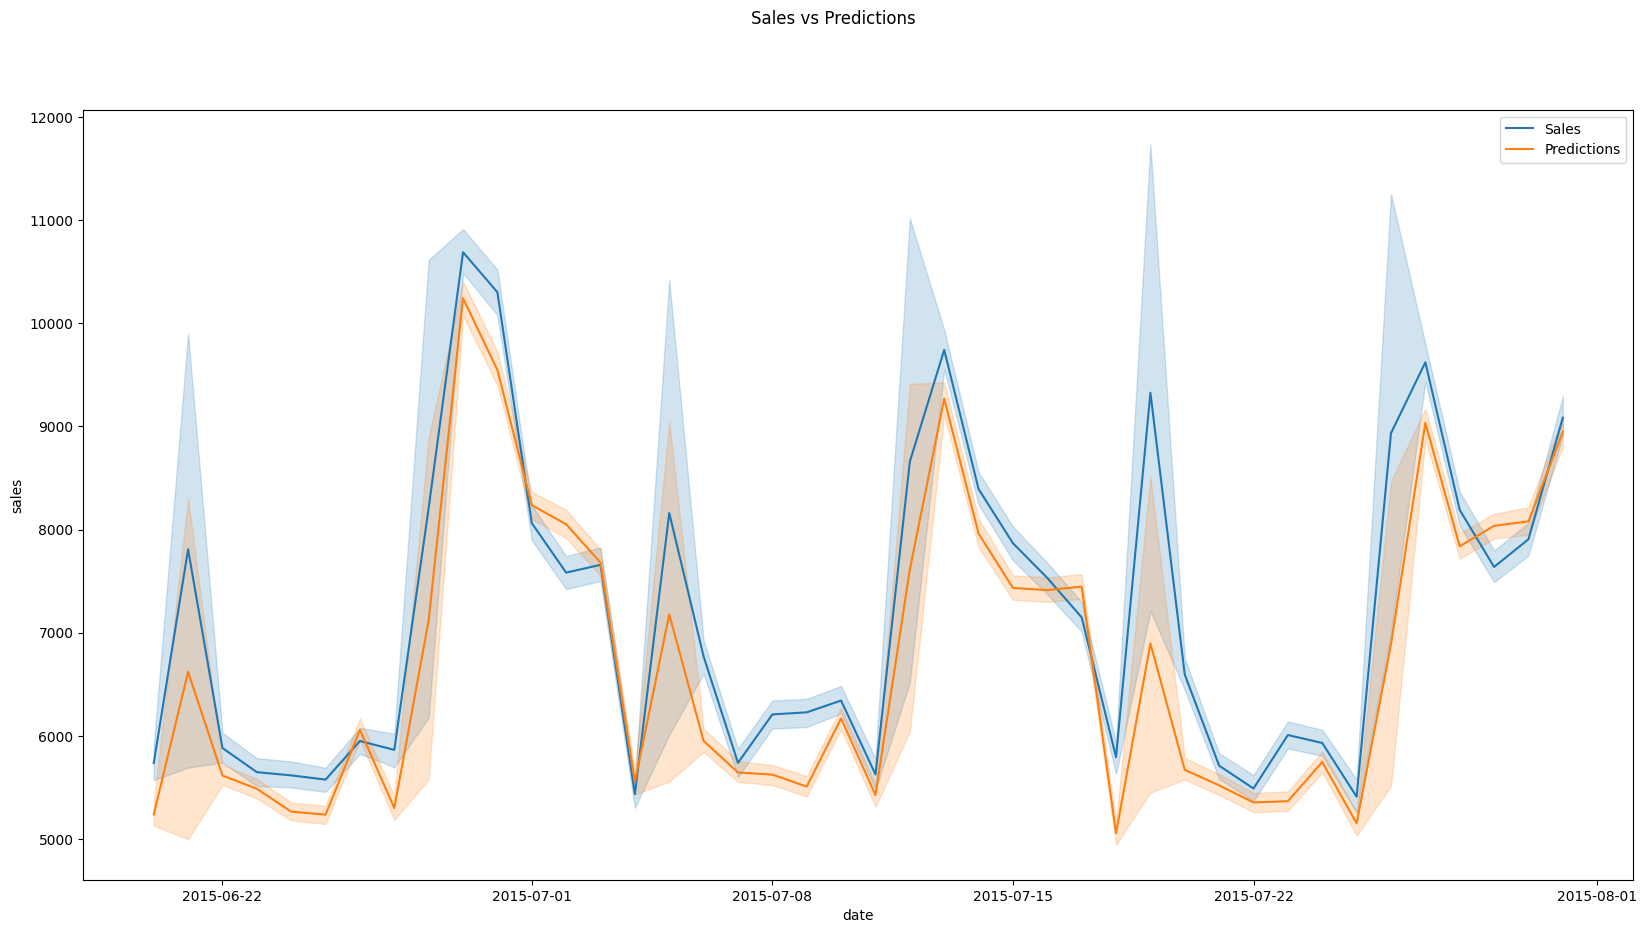

In [16]:
def cor( z ):
    if z>0:
        return "blue"
    else:
        return "red"
    
fig, axes = plt.subplots(1, 1, figsize=(20, 10) )
fig.suptitle('Sales vs Predictions')

sns.lineplot( x='date', y='sales', data=df_business, label='Sales');
sns.lineplot( x='date', y='sales_predictions', data=df_business, label='Predictions');


#for x, y in zip( aux['date'], aux['sales'] ):
#    plt.text(x = x,                       # x-coordinate position of data label
#             y = y-150,                   # y-coordinate position of data label, adjusted to be 150 below the data point
#             s = '{:,.2f}'.format(y),      # data label, formatted to ignore decimals
#            color = 'green')             # set colour of line



#for x, y, z in zip( aux['date'], aux['sales_predictions'], aux['error_percentage'] ):
#    plt.text(x = x,                       # x-coordinate position of data label
#             y = y-150,                   # y-coordinate position of data label, adjusted to be 150 below the data point
#             s = '{:,.2f} ({:.2%})'.format( y, z ),      # data label, formatted to ignore decimals
#            color = cor(z) )             # set colour of line
    

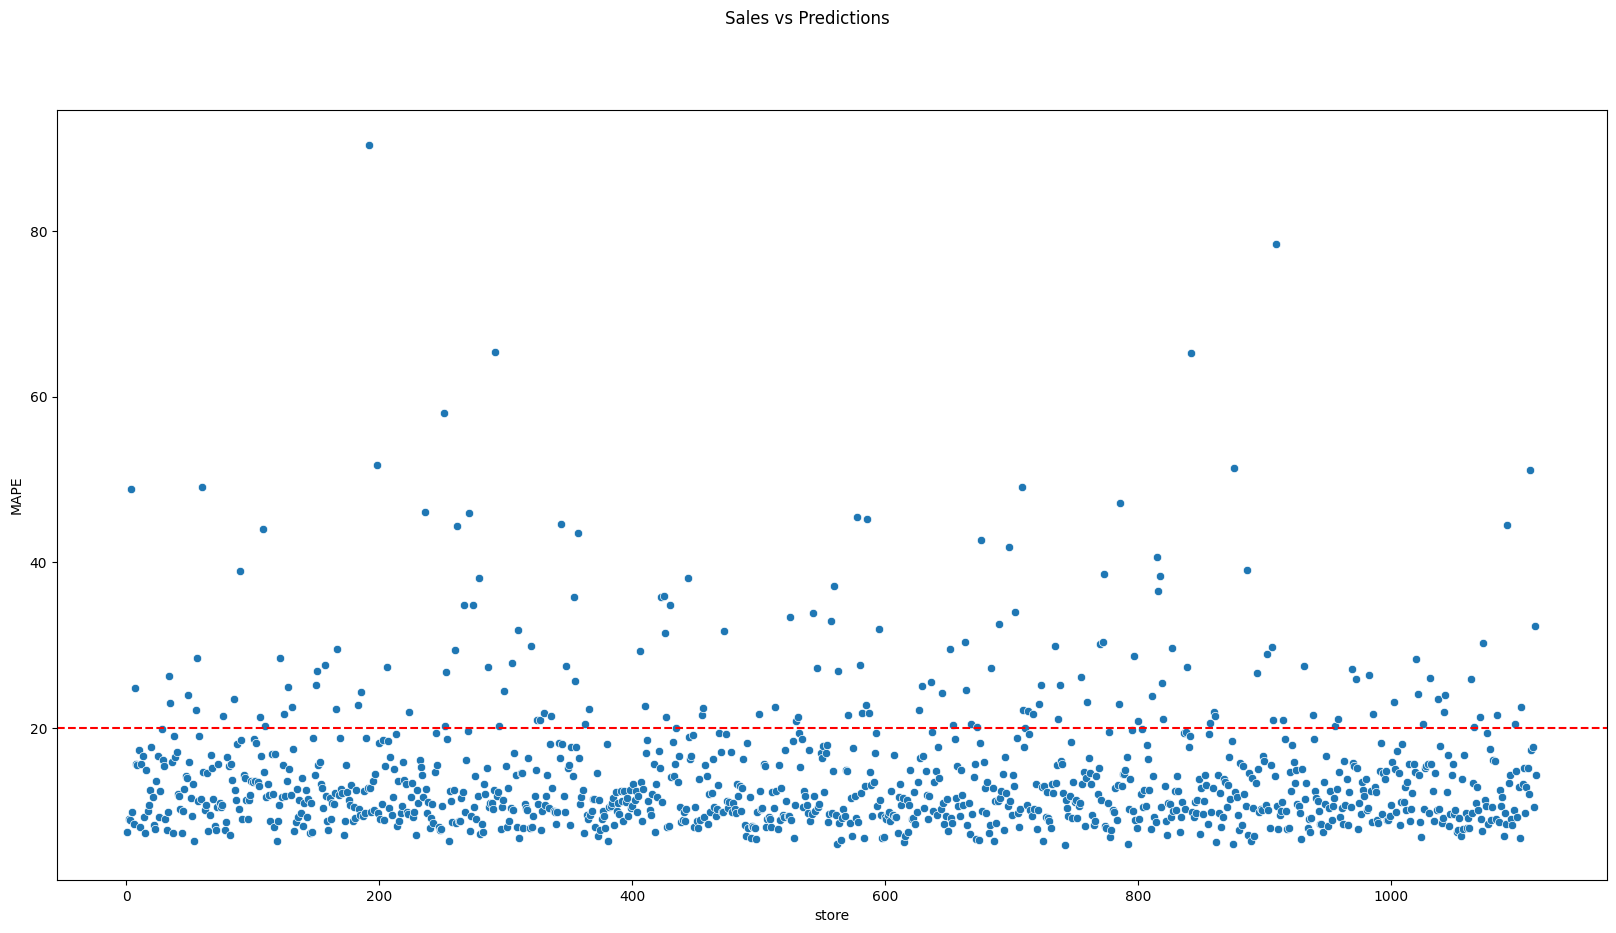

In [24]:
fig, axes = plt.subplots(1, 1, figsize=(20, 10) )
fig.suptitle('Sales vs Predictions')

#plt.axhline( 10, linestyle='--')
plt.axhline( 20, linestyle='--', color='red')
sns.scatterplot( x='store', y='MAPE', data=df_store_performance);

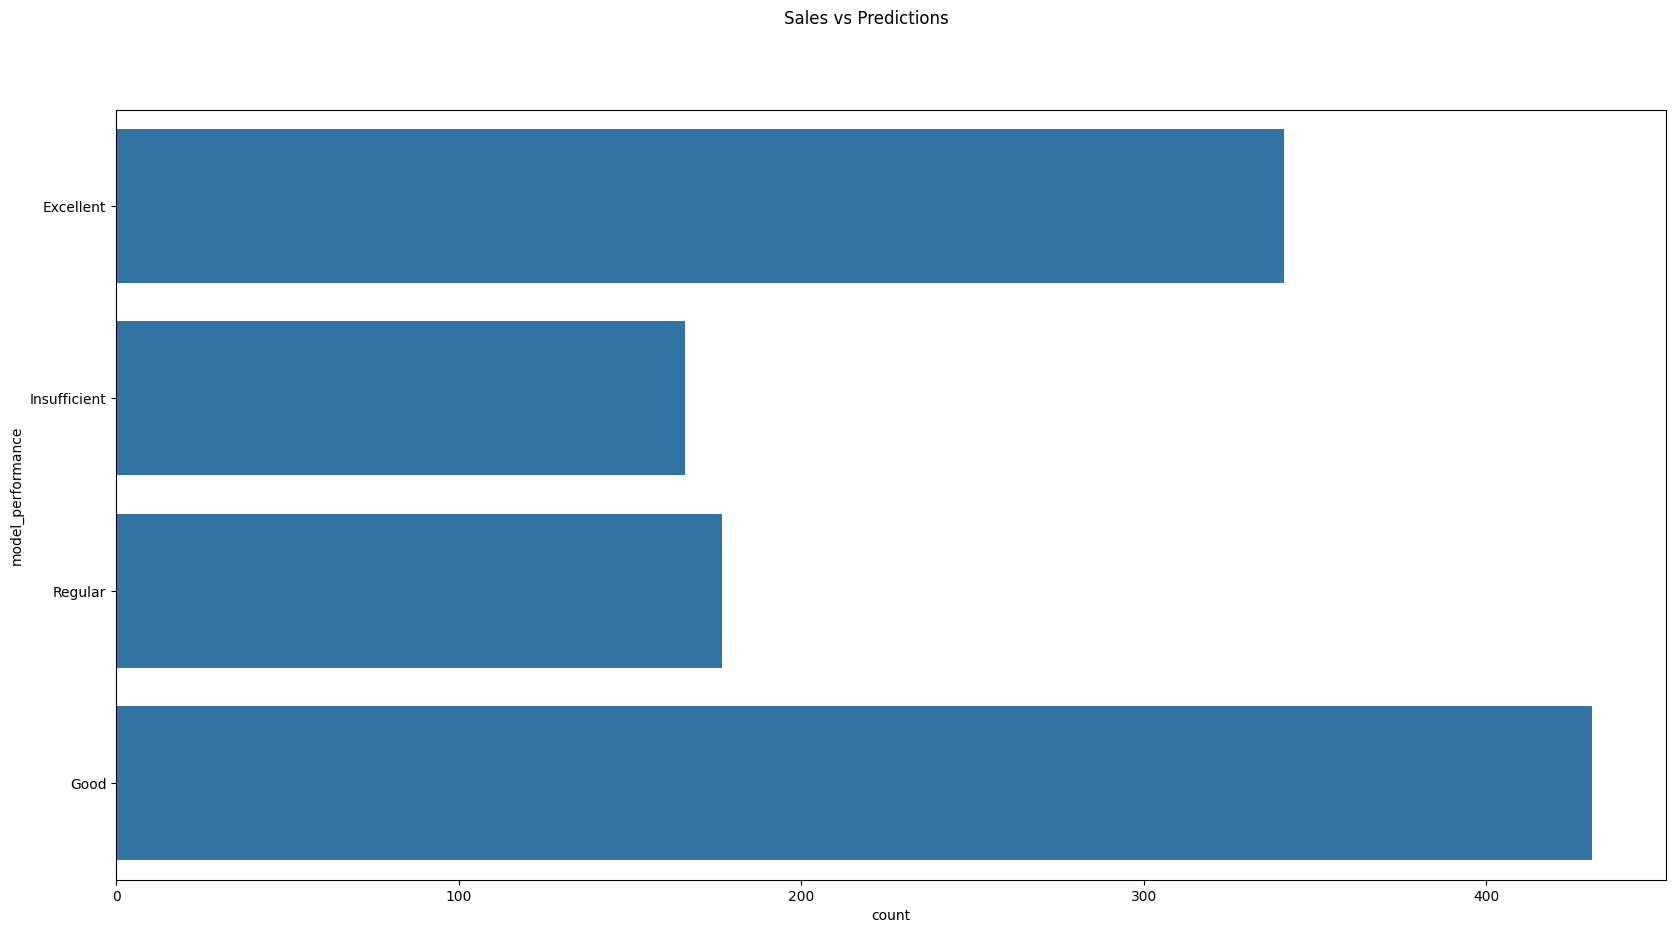

In [19]:
fig, axes = plt.subplots(1, 1, figsize=(20, 10) )
fig.suptitle('Sales vs Predictions')

#aux = df_performance[ (df_performance['store']!=0 ) ]

sns.countplot( data=df_store_performance['model_performance'] );